In [1]:
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from copy import deepcopy
from typing import Dict, List, Tuple

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

In [3]:
# Load DCIts
import sys
import os
sys.path.append('..')
from src.dcits import DCITS

In [4]:
# Load utils
from src.utils import *

In [5]:
# Set random seeds for reproducibility
seed = 1000

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device (index starts from 0, so cuda:0 is the first GPU)
    device = torch.device("cuda:0")
    print(f"Using {torch.cuda.get_device_name(device)}")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

Using NVIDIA RTX A4000


## Data generation parameters

In [7]:
mean = 0
std = 0.1
frequency = 0.3
ts_length = 20000
burn_in = 1000

# Dataset 8

The dataset is defined by the following equations, which depend on the condition of \( X_{1,t-5} \):

### Case 1: $X_{1,t-5} > \frac{1}{2}$
$$
\begin{split}
X_{1,t} &= b_\text{high} + \epsilon_{1,t}, \\
X_{2,t} &= \alpha^\text{gt}_{2,1,5} X_{1,t-5} + \epsilon_{2,t}, \\
X_{3,t} &= \alpha^\text{gt}_{3,1,4} X_{1,t-4} + \epsilon_{3,t}, \\
X_{4,t} &= \alpha^\text{gt}_{4,4,1} X_{4,t-1} + \alpha^\text{gt}_{4,4,4} X_{4,t-4} + \epsilon_{4,t}.
\end{split}
$$

### Case 2: $X_{1,t-5} \leq \frac{1}{2}$
$$
\begin{split}
X_{1,t} &= b_\text{low}  + \epsilon_{1,t}, \\
X_{2,t} &= \alpha^\text{gt}_{2,4,2} X_{4,t-2} + \epsilon_{2,t}, \\
X_{3,t} &= \alpha^\text{gt}_{3,4,4} X_{4,t-4} + \epsilon_{3,t}, \\
X_{4,t} &= \alpha^\text{gt}_{4,4,1} X_{4,t-1} + \alpha^\text{gt}_{4,4,4} X_{4,t-4} + \epsilon_{4,t}.
\end{split}
$$

The ground-truth coefficients and constants are specified as:

$$
\begin{array}{l}
\alpha^\text{gt}_{1,1,1} = \frac{1}{5}, \quad \alpha^\text{gt}_{1,1,3} = \frac{7}{10}, \\
\alpha^\text{gt}_{2,1,5} = \frac{4}{5}, \quad \alpha^\text{gt}_{2,4,2} = \frac{2}{3}, \\
\alpha^\text{gt}_{3,1,4} = \frac{2}{3}, \quad \alpha^\text{gt}_{3,4,4} = \frac{4}{5}, \\
\alpha^\text{gt}_{4,4,1} = \frac{1}{2}, \quad \alpha^\text{gt}_{4,4,4} = \frac{2}{5}.
\end{array}
$$


# Square-Like Process Description

The time series $X_{1,t}$ alternates between two levels, $b_{\text{low}} = 0.2$ and $b_{\text{high}} = 0.7$, with persistence duration drawn from a normal distribution:


$$X_{1,t} =b_t + \epsilon_t, \quad t = 1, 2, \dots, T$$

where:
* $b_t$ is the level at time $t$, which can either be $b_{\text{low}} = 0.2$ or $b_{\text{high}} = 0.7$
* $b_t$ switches between $b_{\text{low}}$ and $b_{\text{high}}$ after a persistence duration, $P$, which is randomly drawn from a normal distribution:

  $P \sim \max(10, \mathcal{N}(\mu_P, \sigma_P))$

with $\mu_P = 50$ (mean persistence) and $\sigma_P = 30$ (standard deviation). The maximum function is used to ensure that the persistence is always at least 10.

* $\epsilon_t$ is Gaussian noise added to the level:

  $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon)$

  with a small variance $\sigma_\epsilon^2$ to allow for slight variability around the levels.

* The switching condition for the level $L_t$ is given by:

  $b_t = \begin{cases} 
  b_{\text{high}}, & \text{if } b_{t-1} = b_{\text{low}} \text{ and } t - t_{\text{last\_switch}} \geq P \\
  b_{\text{low}}, & \text{if } b_{t-1} = b_{\text{high}} \text{ and } t - t_{\text{last\_switch}} \geq P
  \end{cases}$

  where $t_{\text{last\_switch}}$ is the time step when the last switch occurred.

### Summary of Parameters

* $b_{\text{low}} = 0.2$: Lower bound of the square wave
* $b_{\text{high}} = 0.7$: Upper bound of the square wave
* $\mu_P = 50$: Mean persistence duration
* $\sigma_P = 30$: Standard deviation of persistence duration
* $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$ with a small $\sigma_\epsilon^2$: Gaussian noise to introduce slight variability

In [8]:
dataset_name="Dataset 8"

In [13]:
# Parameters
no_of_timeseries_gp = 4  # Four time series (X_1, X_2, X_3, X_4)
window_length_gp = 5     # Maximum lag (window length)

# Initialize the alpha tensors for both cases
ground_truth_alpha_high = torch.zeros(no_of_timeseries_gp, no_of_timeseries_gp, window_length_gp)
ground_truth_alpha_low = torch.zeros_like(ground_truth_alpha_high)

# Case 1: X_{t-5} > 1/2
ground_truth_alpha_high[1, 0, 4] = 4/5   # X2, X1 lag 5
ground_truth_alpha_high[2, 0, 3] = 2/3   # X3, X1 lag 4
ground_truth_alpha_high[3, 3, 0] = 1/2   # X4, X4 lag 1
ground_truth_alpha_high[3, 3, 3] = 2/5   # X4, X4 lag 4

# Case 2: X_{t-5} <= 1/2
ground_truth_alpha_low[1, 3, 1] = 2/3   # X2, X4 lag 2
ground_truth_alpha_low[2, 3, 3] = 4/5   # X3, X4 lag 4 
ground_truth_alpha_low[3, 3, 0] = 1/2   # X4, X4 lag 1 (same as case 1)
ground_truth_alpha_low[3, 3, 3] = 2/5   # X4, X4 lag 4 (same as case 1)

# Create masks for analysis
alpha_mask_high = (ground_truth_alpha_high != 0).float()
alpha_mask_low = (ground_truth_alpha_low != 0).float()

# Create bias tensor
ground_truth_bias_low = torch.tensor([1/5,0,0,0])

# Create bias tensor
ground_truth_bias_high = torch.tensor([7/10,0,0,0])

In [14]:
ground_truth_bias_low,ground_truth_bias_high

(tensor([0.2000, 0.0000, 0.0000, 0.0000]),
 tensor([0.7000, 0.0000, 0.0000, 0.0000]))

In [15]:
beta_high_tilde = torch.abs(ground_truth_alpha_high).sum(axis=-1)

# Compute beta and beta_std
ground_truth_beta_high = beta_high_tilde / beta_high_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
ground_truth_beta_high = torch.where(torch.isnan(ground_truth_beta_high), torch.tensor(0.0), ground_truth_beta_high)
ground_truth_beta_high

tensor([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])

In [16]:
beta_low_tilde = torch.abs(ground_truth_alpha_low).sum(axis=-1)

# Compute beta and beta_std
ground_truth_beta_low = beta_low_tilde / beta_low_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
ground_truth_beta_low = torch.where(torch.isnan(ground_truth_beta_low), torch.tensor(0.0), ground_truth_beta_low)
ground_truth_beta_low

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])

In [17]:
def dataset8(len_of_timeseries, 
             ground_truth_alpha_low, 
             bias_low, 
             ground_truth_alpha_high, 
             bias_high,              
             noise_frequency=0, 
             mu=0, 
             sigma=1, 
             burn_in=1000, 
             seed=None, 
             nonlinear_function=None,
             # Square wave parameters
             low_level=0.2,
             high_level=0.7,
             persistence_mean=50,
             persistence_std=30,
             noise_variance=0.001):
    """
    Generates a multivariate time series where the first series follows a switching pattern
    and the remaining series follow regime-switching dynamics based on X_{1,t-5} > 1/2.
    
    Args:
        len_of_timeseries (int): Length of the time series to generate
        ground_truth_alpha_high (torch.Tensor): Coefficients tensor for case X_{1,t-5} > 1/2
        bias_high (torch.Tensor): Bias term for case X_{1,t-5} > 1/2
        ground_truth_alpha_low (torch.Tensor): Coefficients tensor for case X_{1,t-5} <= 1/2
        bias_low (torch.Tensor): Bias term for case X_{1,t-5} <= 1/2
        noise_frequency (float): Probability of adding noise at each step (0 to 1)
        mu (float): Mean of the Gaussian noise
        sigma (float): Standard deviation of the Gaussian noise
        burn_in (int): Number of initial samples to discard
        seed (int, optional): Seed for random number generation
        nonlinear_function (callable, optional): Nonlinear function to apply after linear combination
        low_level (float): The lower level value of the square wave
        high_level (float): The upper level value of the square wave
        persistence_mean (float): Mean of the persistence duration
        persistence_std (float): Standard deviation of the persistence duration
        noise_variance (float): Variance of the Gaussian noise for square wave
    
    Returns:
        torch.Tensor: Generated time series of shape (no_of_timeseries, len_of_timeseries)
    """
    if seed is not None:
        np.random.seed(seed)
        
    # Set dimensions    
    no_of_timeseries, _, window_length = ground_truth_alpha_high.shape
    total_length = len_of_timeseries + burn_in
    
    # Initialize time series with Gaussian variates N(0,1)
    time_series = torch.tensor(
        np.random.normal(0, 1, (no_of_timeseries, total_length)), 
        dtype=torch.float32
    )
    
    # Generate switching process for the first time series
    square_wave = generate_switching_process_with_random_persistence(
        total_length,
        low_level=low_level,
        high_level=high_level,
        persistence_mean=persistence_mean,
        persistence_std=persistence_std,
        noise_variance=noise_variance,
        seed=None  # Don't set seed again as it's already set above
    )
    
    # Replace the first time series with the switching process
    time_series[0, :] = torch.tensor(square_wave, dtype=torch.float32)
    
    # Generate noise mask only for values after initial window (except for first series)
    noise_mask = (np.random.rand(no_of_timeseries-1, total_length - window_length) < noise_frequency)
    # Add noise as Gaussian variates N(mu,sigma) with mask 
    noise_after_window = np.random.normal(mu, sigma, (no_of_timeseries-1, total_length - window_length)) * noise_mask
    
    # Only apply masked noise after the initial window (for series 2 onwards)
    time_series[1:, window_length:] = torch.tensor(noise_after_window, dtype=torch.float32)
    
    # Populate the time series based on lagged values (only for series 2 onwards)
    for t in range(window_length, total_length):
        # Get all relevant lags at once
        lagged_values = time_series[:, t-window_length:t].flip(1)
        
        # Check condition X_{1,t-5} > 1/2 using the first time series (X_1)
        if time_series[0, t-5] > 0.5:
            # Case 1: Use ground_truth_alpha_1 and bias_1
            lagged_sum = torch.einsum('ijk,jk->i', ground_truth_alpha_high, lagged_values)
            transition_value = lagged_sum #+ bias_high
        else:
            # Case 2: Use ground_truth_alpha_2 and bias_2
            lagged_sum = torch.einsum('ijk,jk->i', ground_truth_alpha_low, lagged_values)
            transition_value = lagged_sum #+ bias_low
            
        if nonlinear_function:
            transition_value = nonlinear_function(transition_value)
        
        # Update only series 2 onwards
        time_series[1:, t] = transition_value[1:] + time_series[1:, t]
    
    # Drop the burn-in samples
    return time_series[:, burn_in:]

def generate_switching_process_with_random_persistence(len_of_series, 
                                                       low_level=0.2, 
                                                       high_level=0.7, 
                                                       persistence_mean=20, 
                                                       persistence_std=5, 
                                                       noise_variance=0.001, 
                                                       seed=None):
    """
    Generates a time series that behaves in a switching manner, oscillating between low_level and high_level,
    with random persistence durations drawn from a normal distribution.
    
    Args:
        len_of_series (int): Length of the time series to generate.
        low_level (float): The lower level value of the square wave.
        high_level (float): The upper level value of the square wave.
        persistence_mean (float): Mean of the persistence duration.
        persistence_std (float): Standard deviation of the persistence duration.
        noise_variance (float): Variance of the Gaussian noise to add to the series.
        seed (int, optional): Seed for reproducibility.
    
    Returns:
        np.ndarray: Generated time series of length `len_of_series`.
    """
    if seed is not None:
        np.random.seed(seed)
    
    series = np.zeros(len_of_series)
    current_level = low_level
    current_persistence = 0
    persistence_duration = max(10, int(np.random.normal(persistence_mean, persistence_std)))

    for t in range(len_of_series):
        noise = np.random.normal(0, np.sqrt(noise_variance))
        series[t] = current_level + noise
        current_persistence += 1
        
        if current_persistence >= persistence_duration:
            current_level = high_level if current_level == low_level else low_level
            current_persistence = 0
            persistence_duration = max(10, int(np.random.normal(persistence_mean, persistence_std)))

    return series

In [18]:
time_series = dataset8(ts_length, ground_truth_alpha_low, ground_truth_bias_low, 
                           ground_truth_alpha_high,ground_truth_bias_high, noise_frequency=frequency, 
                           mu=mean, sigma=std, low_level=ground_truth_bias_low[0], high_level=ground_truth_bias_high[0], 
                           seed=seed)

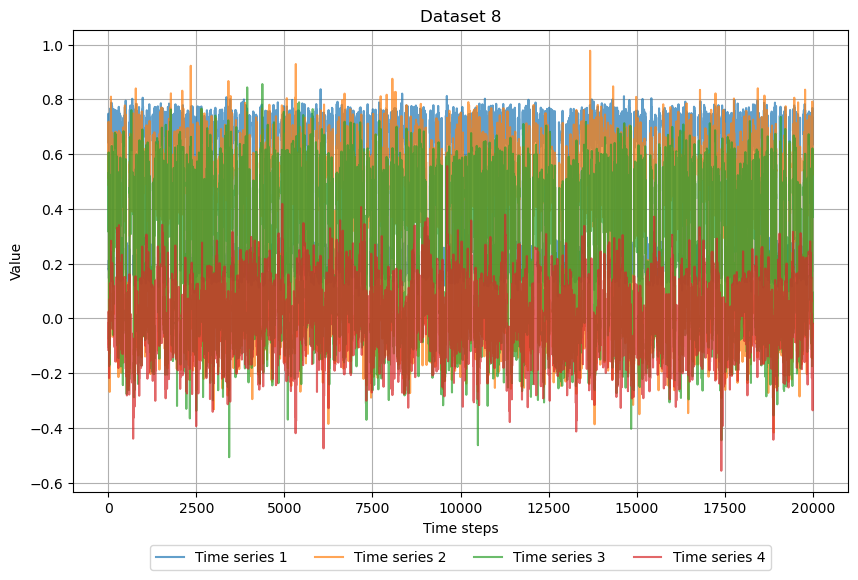

In [19]:
plot_ts(time_series, dataset_name=dataset_name,alpha=0.7)

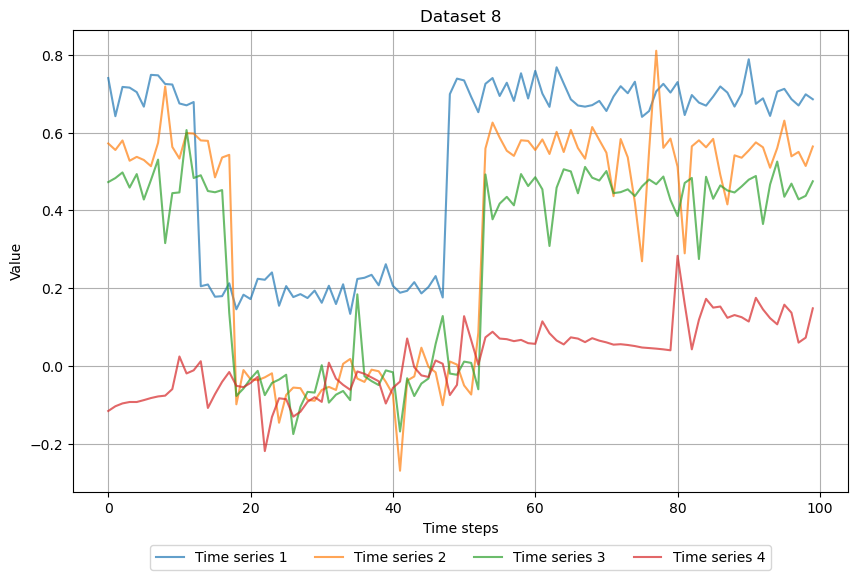

In [20]:
plot_ts(time_series[:,:100], dataset_name=dataset_name,alpha=0.7)

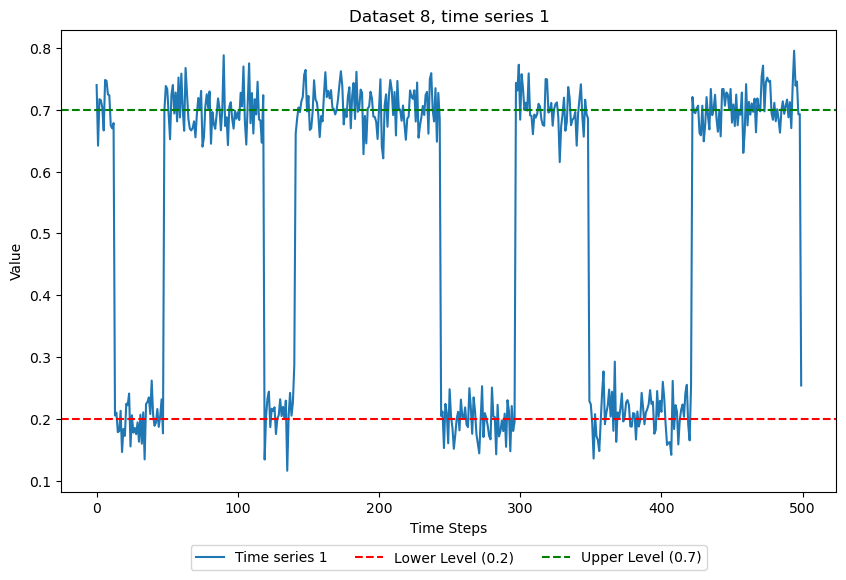

In [21]:
# Plot the series
plt.figure(figsize=(10, 6))
plt.plot(time_series[0,:500], label="Time series 1")
plt.axhline(0.2, color="red", linestyle="--", label="Lower Level (0.2)")
plt.axhline(0.7, color="green", linestyle="--", label="Upper Level (0.7)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Dataset 8, time series 1")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4);

The maximum window length is: 136
The minimum window length is: 10


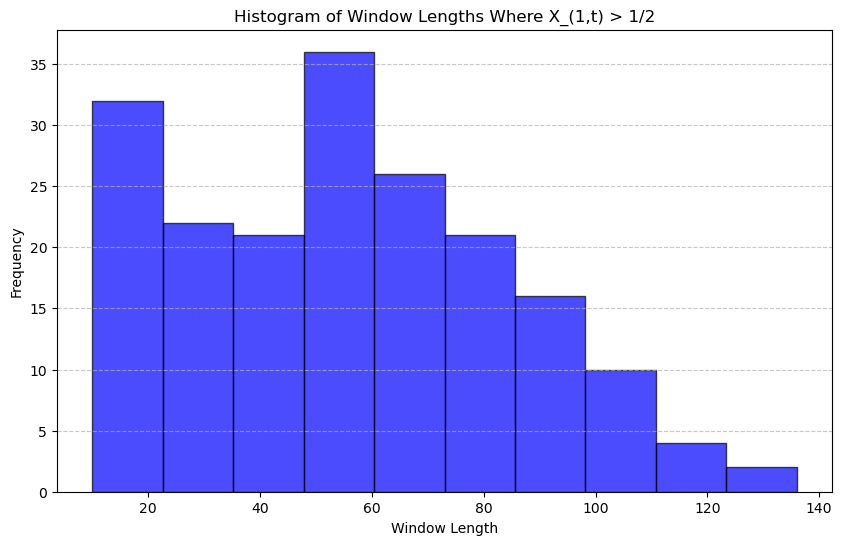

In [22]:
# Assuming `time_series` is the dataset and we are analyzing the first time series
# Extract the first time series
time_series_1 = time_series[0]  # Full first time series

# Initialize a list to store window lengths
window_lengths = []

# Initialize variables to track the start of the window
in_window = False
start_index = None

# Iterate through the time series
for i, value in enumerate(time_series_1):
    if value > 0.5:
        if not in_window:
            # Start a new window
            in_window = True
            start_index = i
    else:
        if in_window:
            # End the current window and calculate its length
            in_window = False
            window_length = i - start_index
            window_lengths.append(window_length)

# Find the maximum and minimum values
max_value = np.max(window_lengths)
min_value = np.min(window_lengths)

# Print the results with explanatory text
print(f"The maximum window length is: {max_value}")
print(f"The minimum window length is: {min_value}")

# Plot the histogram of window lengths
plt.figure(figsize=(10, 6))
plt.hist(window_lengths, alpha=0.7, color="blue", edgecolor="black")
plt.title("Histogram of Window Lengths Where X_(1,t) > 1/2")
plt.xlabel("Window Length")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

In [23]:
# Assuming `dataset8_sample` is the generated dataset from the function
# Define the number of splits
num_splits = 10

# Get the length of the dataset
len_of_series = time_series.shape[1]

# Determine the length of each split
split_length = len_of_series // num_splits

# Initialize lists to store percentages
percent_greater = []
percent_less = []

# Loop through each split
for i in range(num_splits):
    # Extract the current split
    split = time_series[0, i * split_length: (i + 1) * split_length]
    
    # Calculate percentages
    greater_than_half = (split > 0.5).float().mean().item() * 100
    less_than_half = (split <= 0.5).float().mean().item() * 100
    
    # Append to lists
    percent_greater.append(greater_than_half)
    percent_less.append(less_than_half)

# Print the results
for i, (greater, less) in enumerate(zip(percent_greater, percent_less)):
    print(f"Split {i + 1}: X1 > 1/2: {greater:.2f}%, X1 <= 1/2: {less:.2f}%")

Split 1: X1 > 1/2: 60.00%, X1 <= 1/2: 40.00%
Split 2: X1 > 1/2: 50.85%, X1 <= 1/2: 49.15%
Split 3: X1 > 1/2: 53.15%, X1 <= 1/2: 46.85%
Split 4: X1 > 1/2: 50.80%, X1 <= 1/2: 49.20%
Split 5: X1 > 1/2: 52.35%, X1 <= 1/2: 47.65%
Split 6: X1 > 1/2: 54.70%, X1 <= 1/2: 45.30%
Split 7: X1 > 1/2: 50.55%, X1 <= 1/2: 49.45%
Split 8: X1 > 1/2: 56.65%, X1 <= 1/2: 43.35%
Split 9: X1 > 1/2: 52.85%, X1 <= 1/2: 47.15%
Split 10: X1 > 1/2: 44.20%, X1 <= 1/2: 55.80%


# Train 

In [25]:
train_config = {
    'verbose': True,
    'device' : device,
    'learning_rate': 1e-3,
    'scheduler_patience': 5,
    'early_stopping_modifier': 2,
    #'criterion': nn.MSELoss() # MSE
    'criterion': nn.L1Loss() # MAE
}

In [26]:
test_loss, train_losses, val_losses, f_test, c_test, debug_info,test_inputs,_,_ = train_and_evaluate(
    time_series=time_series,
    window_size=5,
    temperature=1,
    order=[1,1],
    config=train_config
)

Epoch 1/100, Train Loss: 5.378446e-02, Val Loss: 3.595815e-02, LR: 1.00e-03
Epoch 2/100, Train Loss: 3.499786e-02, Val Loss: 3.823085e-02, LR: 1.00e-03
Epoch 3/100, Train Loss: 3.248259e-02, Val Loss: 3.157524e-02, LR: 1.00e-03
Epoch 4/100, Train Loss: 3.081037e-02, Val Loss: 2.952534e-02, LR: 1.00e-03
Epoch 5/100, Train Loss: 3.072631e-02, Val Loss: 2.949923e-02, LR: 1.00e-03
Epoch 6/100, Train Loss: 2.976463e-02, Val Loss: 2.948642e-02, LR: 1.00e-03
Epoch 7/100, Train Loss: 2.950575e-02, Val Loss: 3.046022e-02, LR: 1.00e-03
Epoch 8/100, Train Loss: 2.887044e-02, Val Loss: 2.929357e-02, LR: 1.00e-03
Epoch 9/100, Train Loss: 2.865037e-02, Val Loss: 2.776009e-02, LR: 1.00e-03
Epoch 10/100, Train Loss: 2.811999e-02, Val Loss: 2.738540e-02, LR: 1.00e-03
Epoch 11/100, Train Loss: 2.808133e-02, Val Loss: 2.726544e-02, LR: 1.00e-03
Epoch 12/100, Train Loss: 2.789516e-02, Val Loss: 2.765457e-02, LR: 1.00e-03
Epoch 13/100, Train Loss: 2.776933e-02, Val Loss: 2.688012e-02, LR: 1.00e-03
Epoch 14

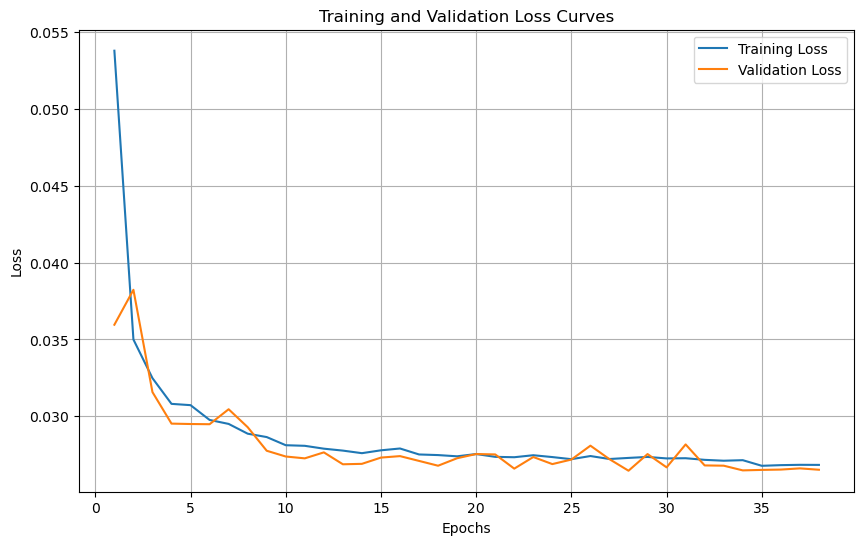

In [27]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)

# Interpretability

In [28]:
# # Compute beta_tilde_tmp, beta_tilde, and beta_tilde_std using NumPy
# beta_tilde_tmp = np.abs(f_test[1] * c_test[1]).sum(axis=-1)  # sum along the last axis
# beta_tilde = beta_tilde_tmp.mean(axis=0)  # mean along the 0th axis
# beta_tilde_std = beta_tilde_tmp.std(axis=0)  # std along the 0th axis

# # Compute beta and beta_std
# beta = beta_tilde / beta_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
# beta_std = (beta_tilde_tmp / beta_tilde_tmp.sum(axis=1, keepdims=True)).std(axis=0)  # std after normalization

In [29]:
alpha = {}
alpha_std = {}

# Create the mask based on `test_inputs`
mask = test_inputs[:, 0, 0] > 0.5

for i in f_test.keys():
    if i == 0:
        # Apply mask to f_test[0] and c_test[0]
        f_bias_low = f_test[0][~mask]
        c_bias_low = c_test[0][~mask]
        f_bias_high = f_test[0][mask]
        c_bias_high = c_test[0][mask]

        # Compute alpha_bias and alpha_bias_std for low
        alpha_bias_low = (f_bias_low * c_bias_low).mean(0)
        alpha_bias_std_low = (f_bias_low * c_bias_low).std(0)

        # Compute alpha_bias and alpha_bias_std for high
        alpha_bias_high = (f_bias_high * c_bias_high).mean(0)
        alpha_bias_std_high = (f_bias_high * c_bias_high).std(0)
    else:
        # Apply mask to f_test[i] and c_test[i]
        f_low = f_test[i][~mask]
        c_low = c_test[i][~mask]
        f_high = f_test[i][mask]
        c_high = c_test[i][mask]

        # Compute alpha and alpha_std for low
        alpha[f"{i}_low"] = (f_low * c_low).mean(0)
        alpha_std[f"{i}_low"] = (f_low * c_low).std(0)

        # Compute alpha and alpha_std for high
        alpha[f"{i}_high"] = (f_high * c_high).mean(0)
        alpha_std[f"{i}_high"] = (f_high * c_high).std(0)

# Collect bias results
alpha_bias_results = {
    'low': {
        'mean': alpha_bias_low,
        'std': alpha_bias_std_low
    },
    'high': {
        'mean': alpha_bias_high,
        'std': alpha_bias_std_high
    }
}

## $\alpha$ bias

In [41]:
print_bias(alpha_bias_results['low']['mean'], alpha_bias_results['low']['std'], ground_truth_bias_low)

bias_1 = (0.194305 ± 0.000002), gt_bias_1 = 0.200000
bias_2 = (-0.000193357 ± 0.000000002), gt_bias_2 = 0.000000000
bias_3 = (-0.000183274 ± 0.000000005), gt_bias_3 = 0.000000000
bias_4 = (0.0000532418 ± 0.0000000002), gt_bias_4 = 0.0000000000


In [42]:
print_bias(alpha_bias_results['high']['mean'], alpha_bias_results['high']['std'], ground_truth_bias_high)

bias_1 = (0.194305 ± 0.000002), gt_bias_1 = 0.700000
bias_2 = (-0.000193357 ± 0.000000002), gt_bias_2 = 0.000000000
bias_3 = (-0.000183274 ± 0.000000004), gt_bias_3 = 0.000000000
bias_4 = (0.0000532418 ± 0.0000000002), gt_bias_4 = 0.0000000000


## $\alpha$ first order

In [46]:
print_significant_alpha(alpha['1_low'], alpha_std['1_low'],ground_truth_alpha_low,threshold=0.05)

alpha_242 = (0.666 ± 0.001), gt_alpha_242 = 0.667
alpha_344 = (0.802 ± 0.003), gt_alpha_344 = 0.800
alpha_441 = (0.5000 ± 0.0003), gt_alpha_441 = 0.5000
alpha_444 = (0.4007 ± 0.0009), gt_alpha_444 = 0.4000


In [47]:
print_significant_alpha(alpha['1_high'], alpha_std['1_high'],ground_truth_alpha_high,threshold=0.05)

alpha_111 = (0.34 ± 0.09) Not in ground truth
alpha_112 = (0.21 ± 0.06) Not in ground truth
alpha_115 = (0.06 ± 0.02) Not in ground truth
alpha_215 = (0.793 ± 0.002), gt_alpha_215 = 0.800
alpha_314 = (0.666 ± 0.002), gt_alpha_314 = 0.667
alpha_441 = (0.502 ± 0.001), gt_alpha_441 = 0.500
alpha_444 = (0.3963 ± 0.0009), gt_alpha_444 = 0.4000


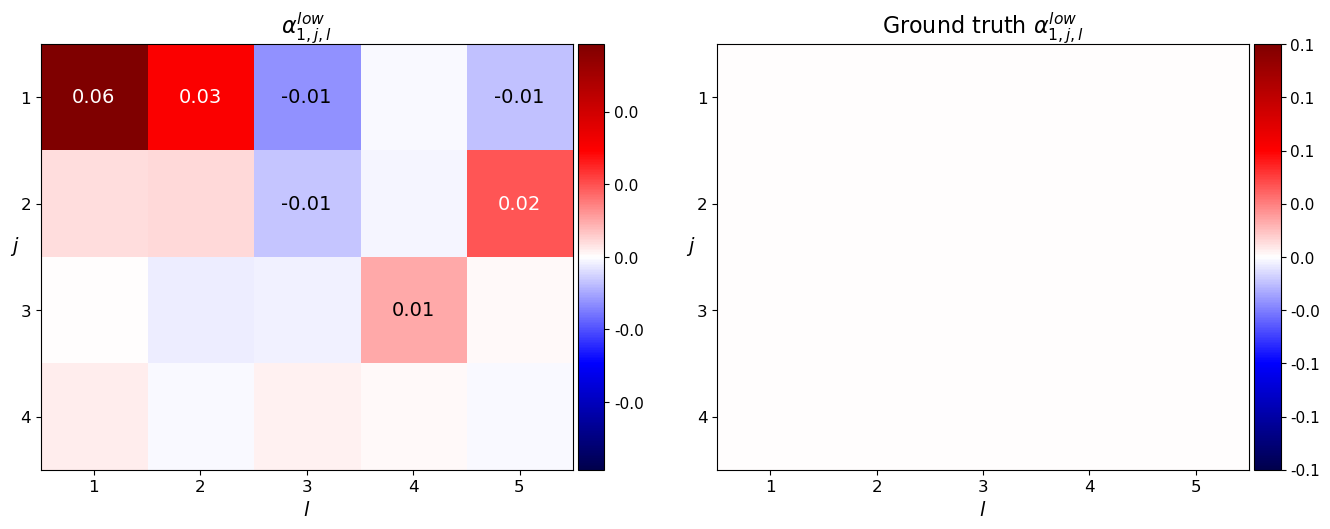

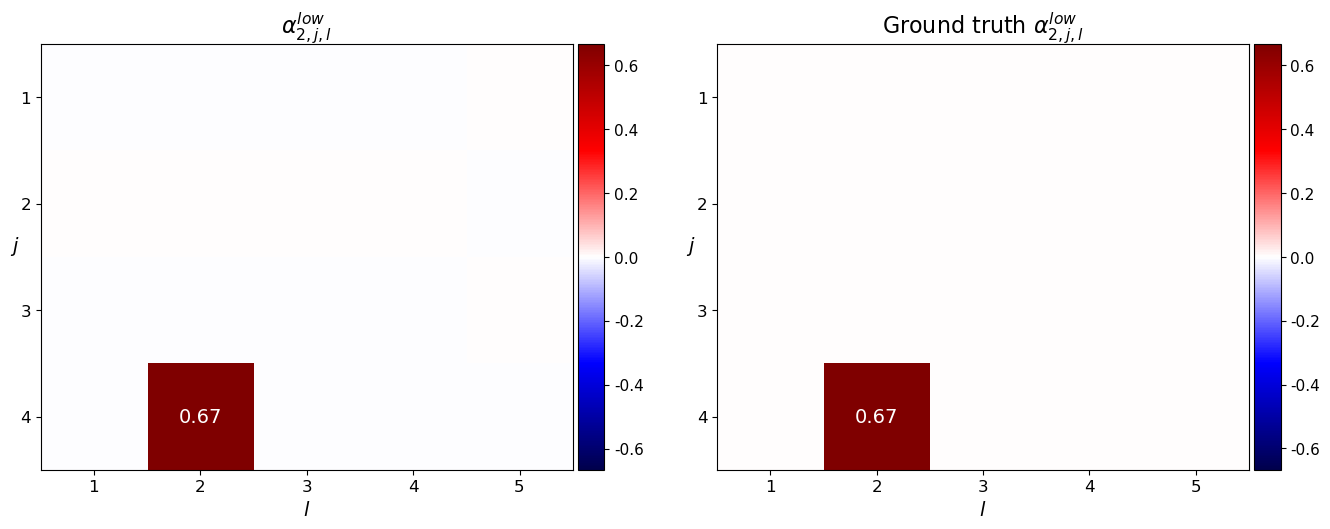

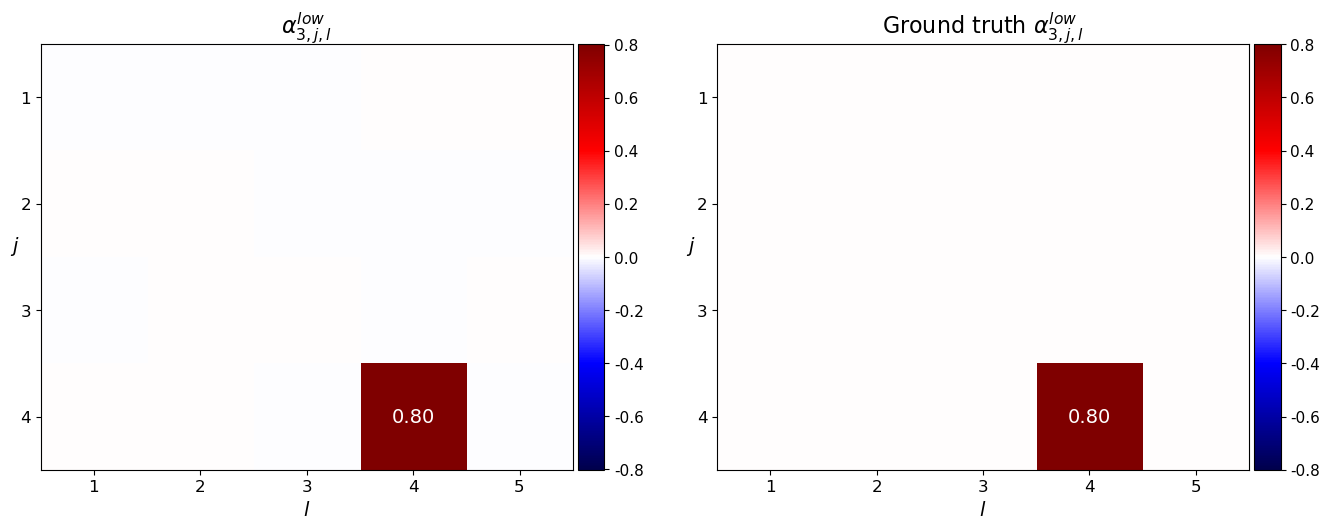

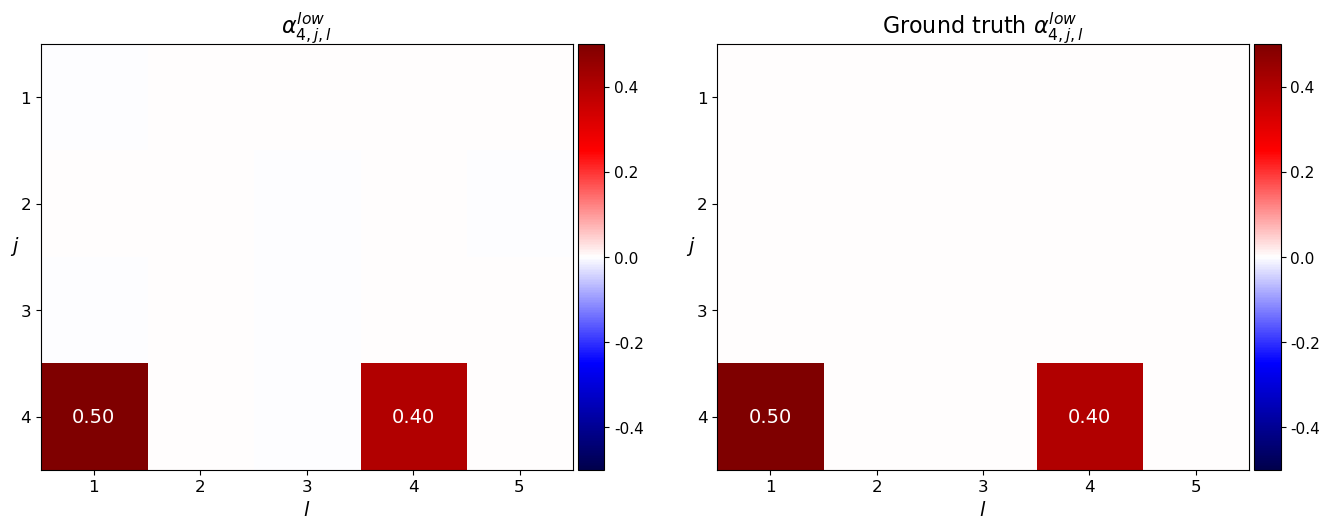

In [48]:
plot_alphas(alpha['1_low'],ground_truth_alpha_low, figsize=(8, 7), title=r'\alpha^{low}',font_size=14, space=0.2, force_12=True)

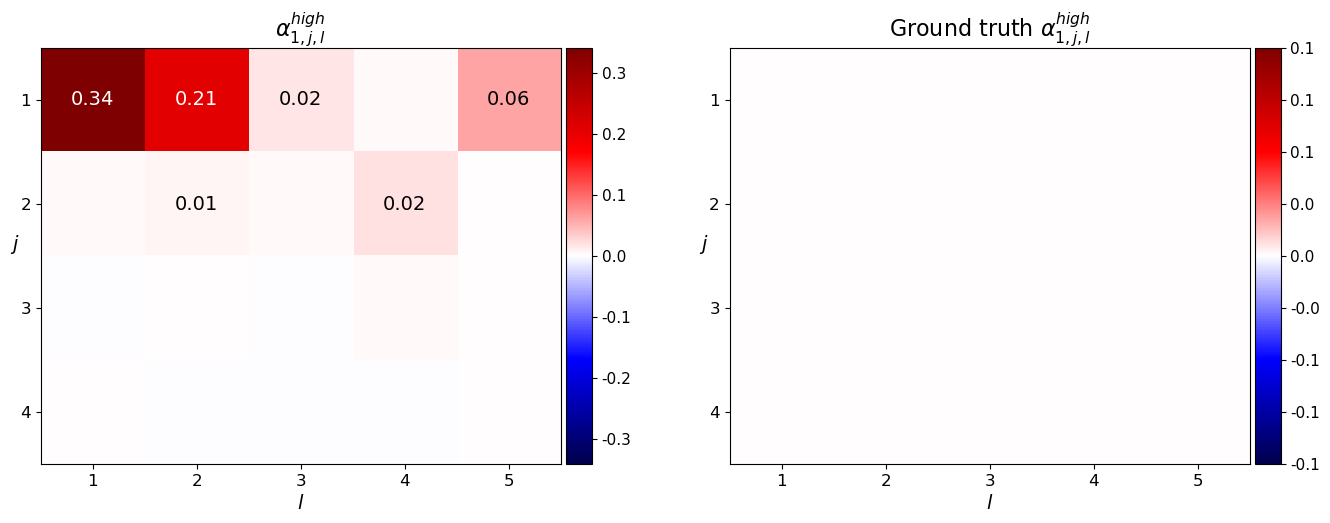

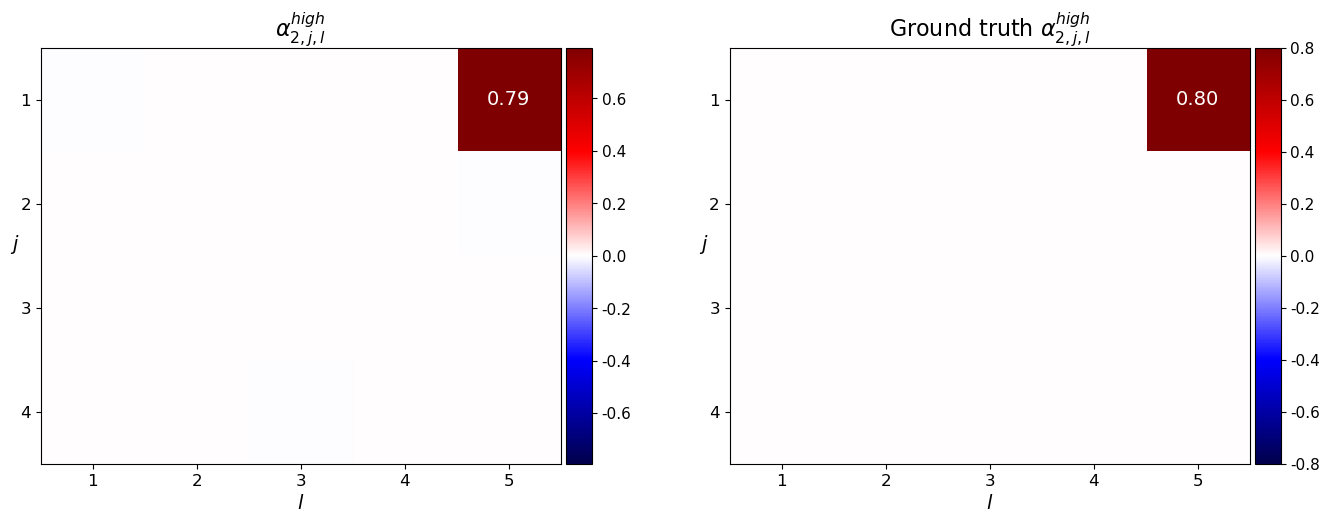

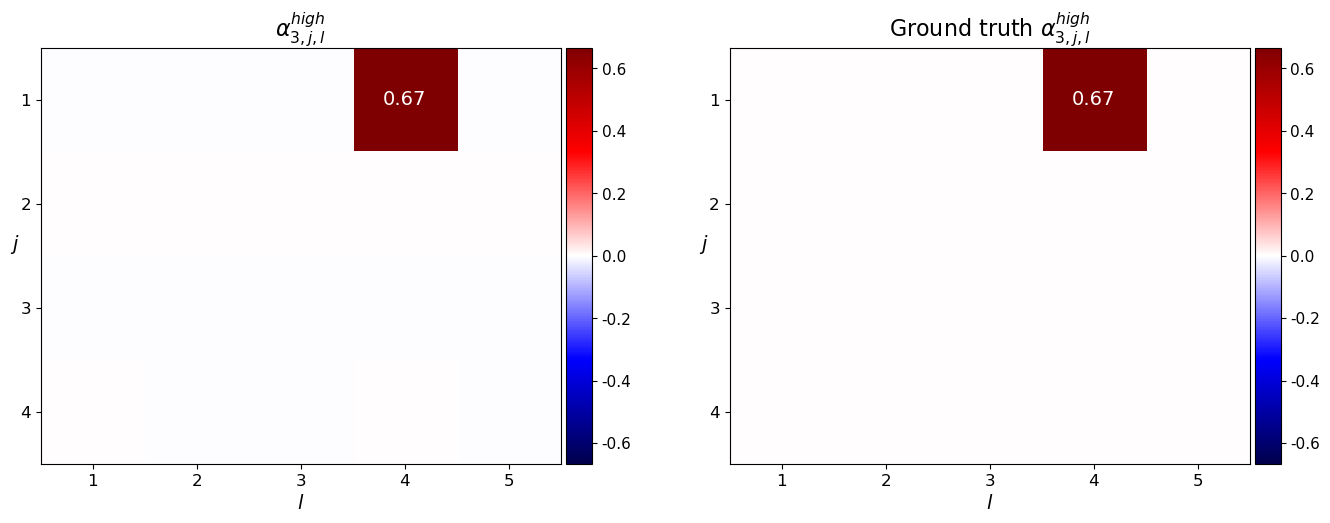

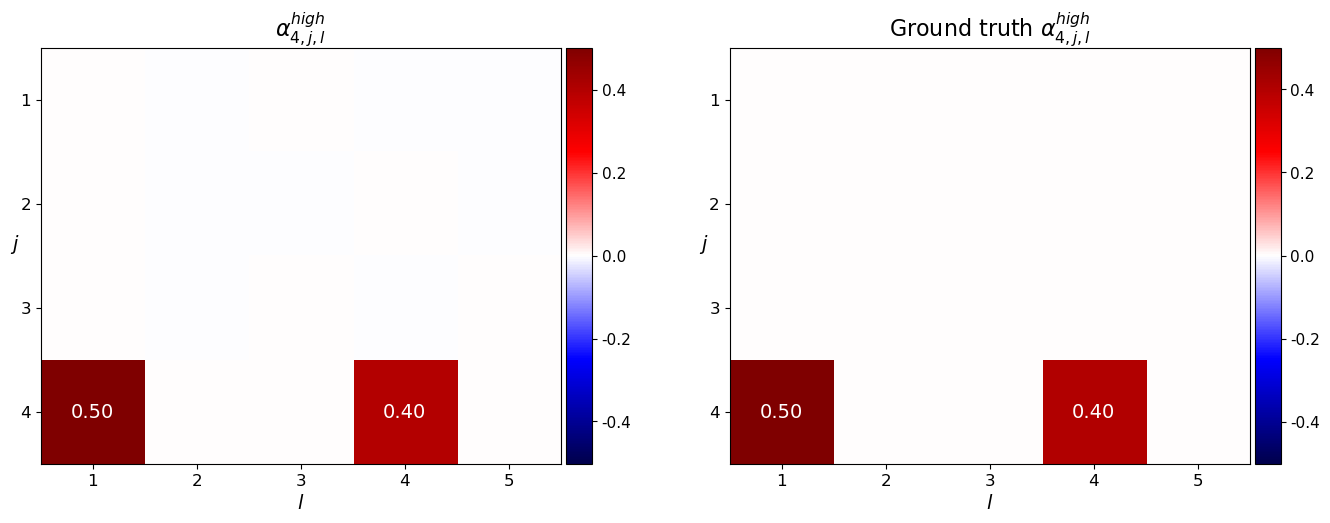

In [49]:
plot_alphas(alpha['1_high'],ground_truth_alpha_high, figsize=(8, 7), title=r'\alpha^{high}',font_size=14, space=0.25, force_12=True)

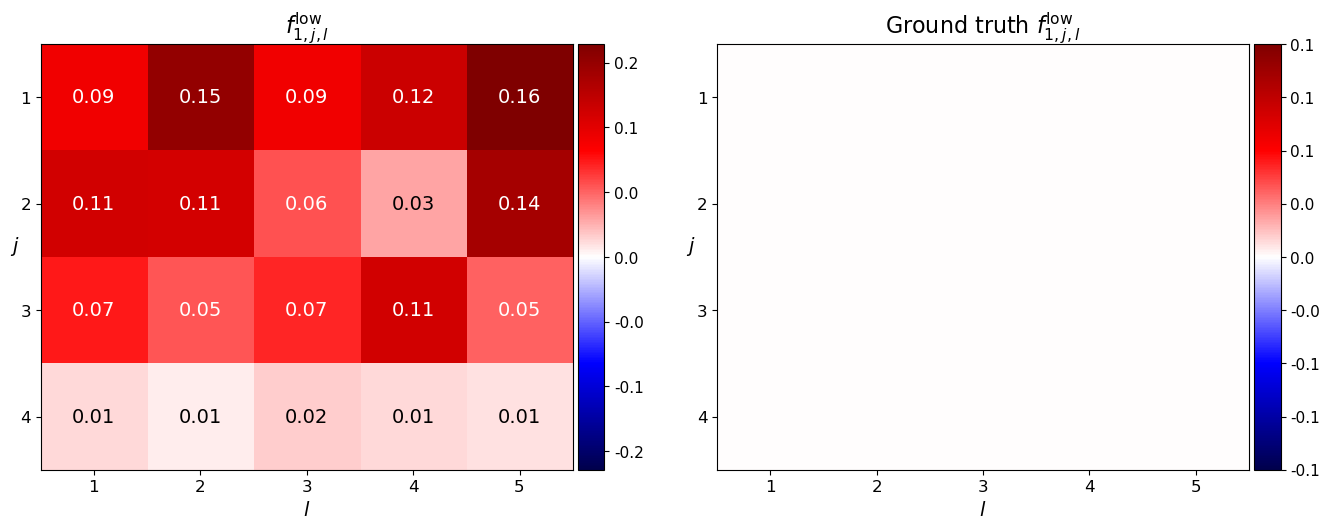

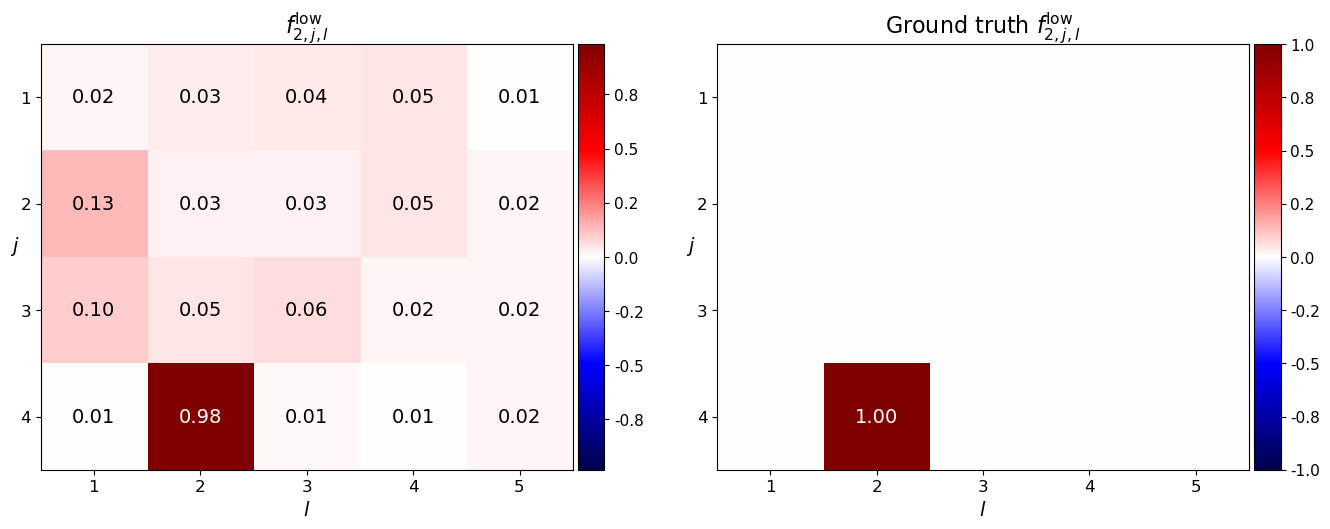

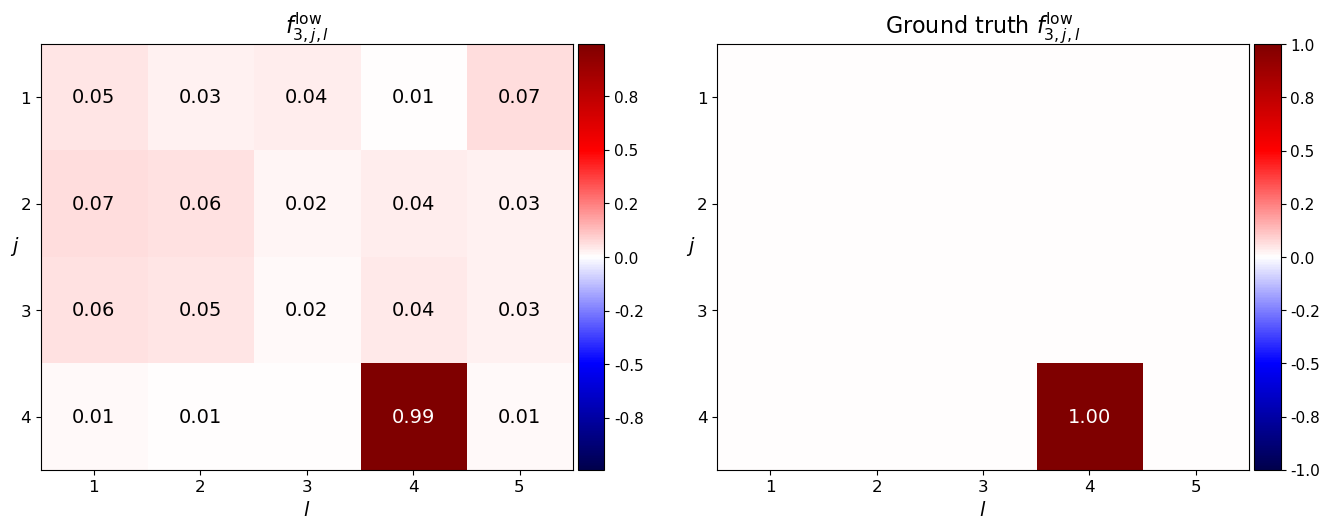

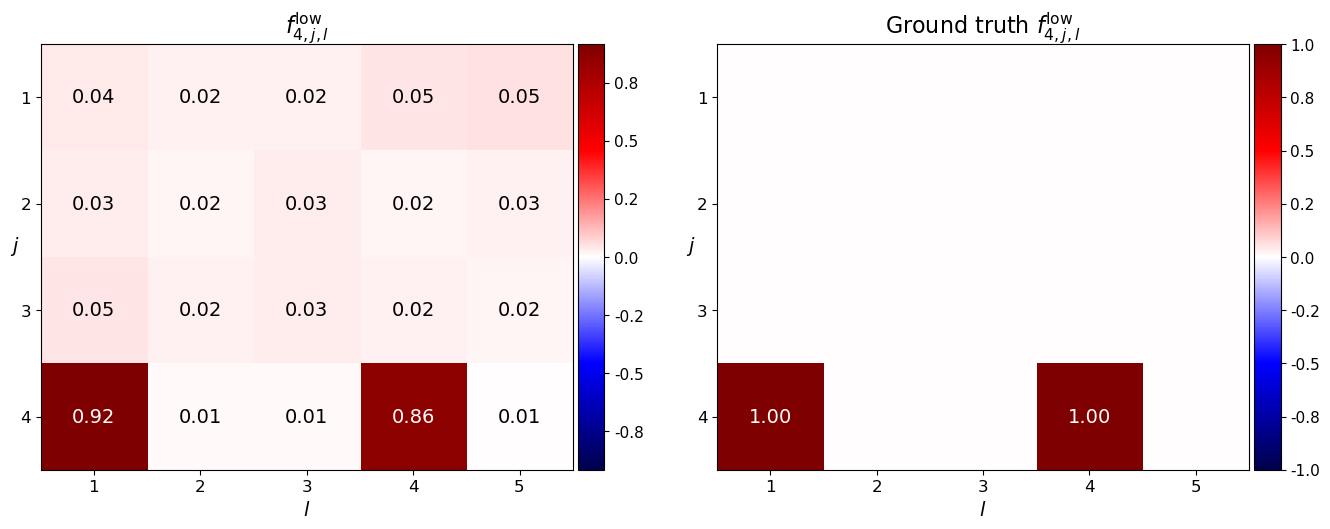

In [50]:
plot_alphas(f_low.mean(0),alpha_mask_low, title=r'f^\text{low}', figsize=(8, 7), font_size=14, space=0.2, force_12=True)

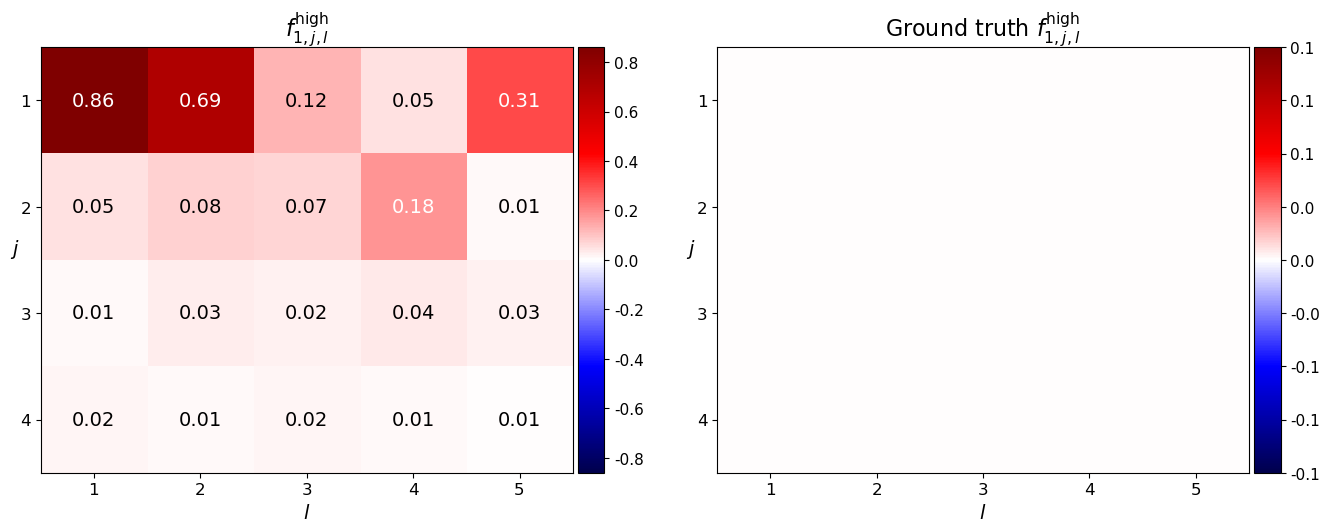

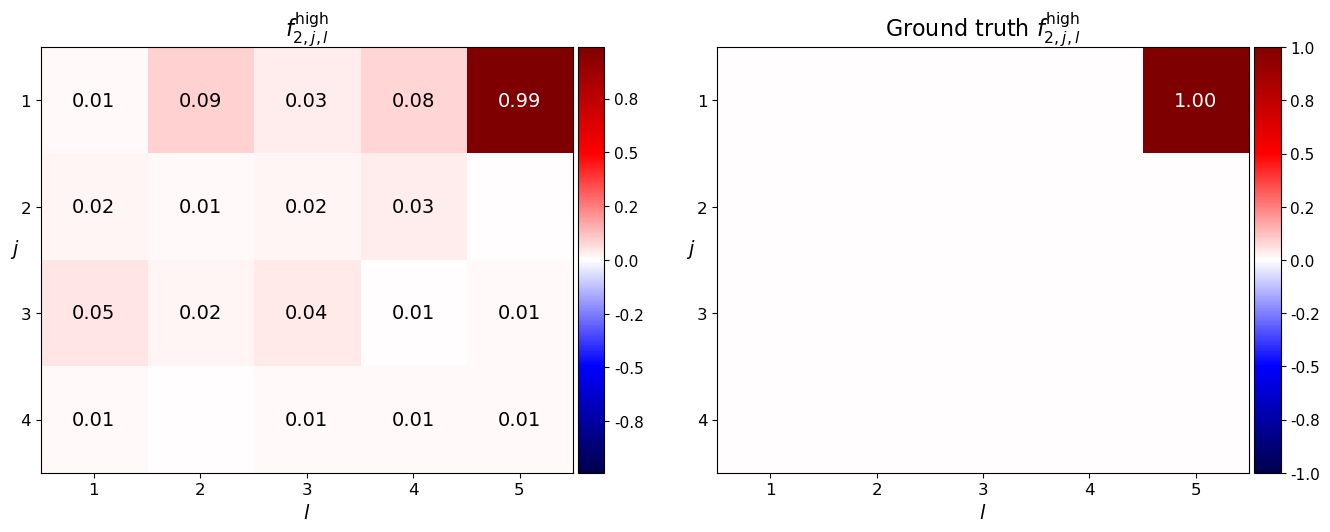

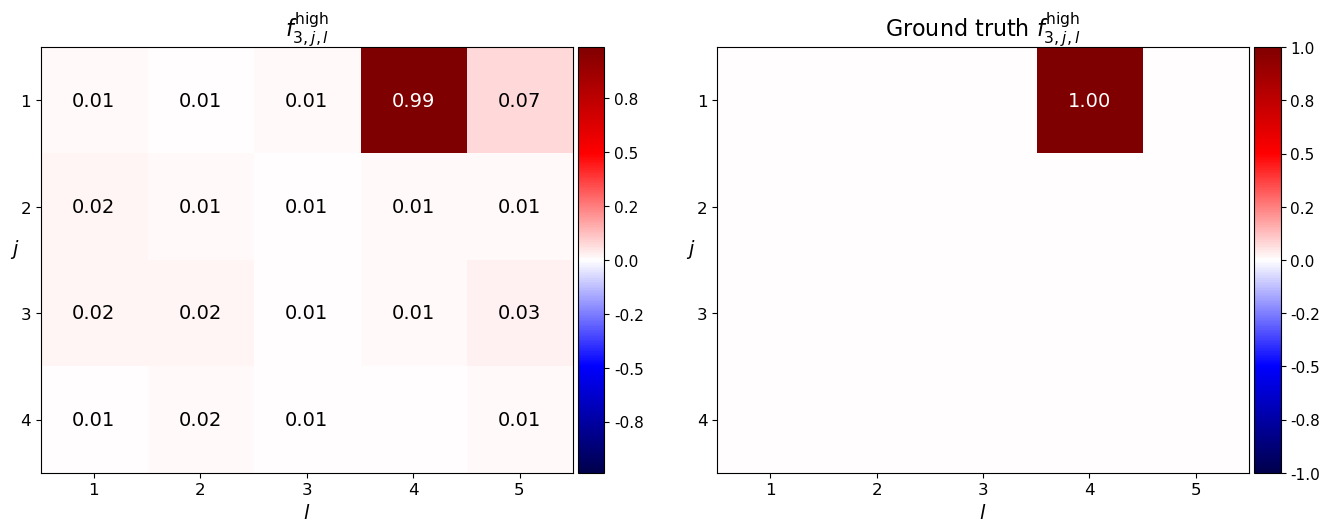

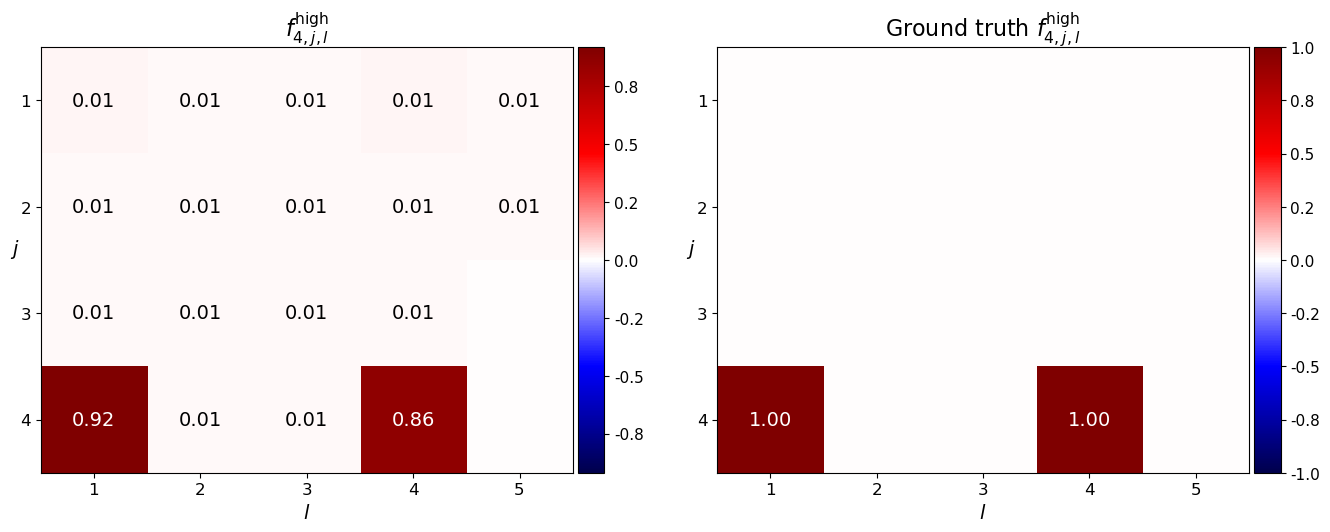

In [54]:
plot_alphas(f_high.mean(0),alpha_mask_high, title=r'f^\text{high}', figsize=(8, 7), font_size=14, space=0.2, force_12=True)

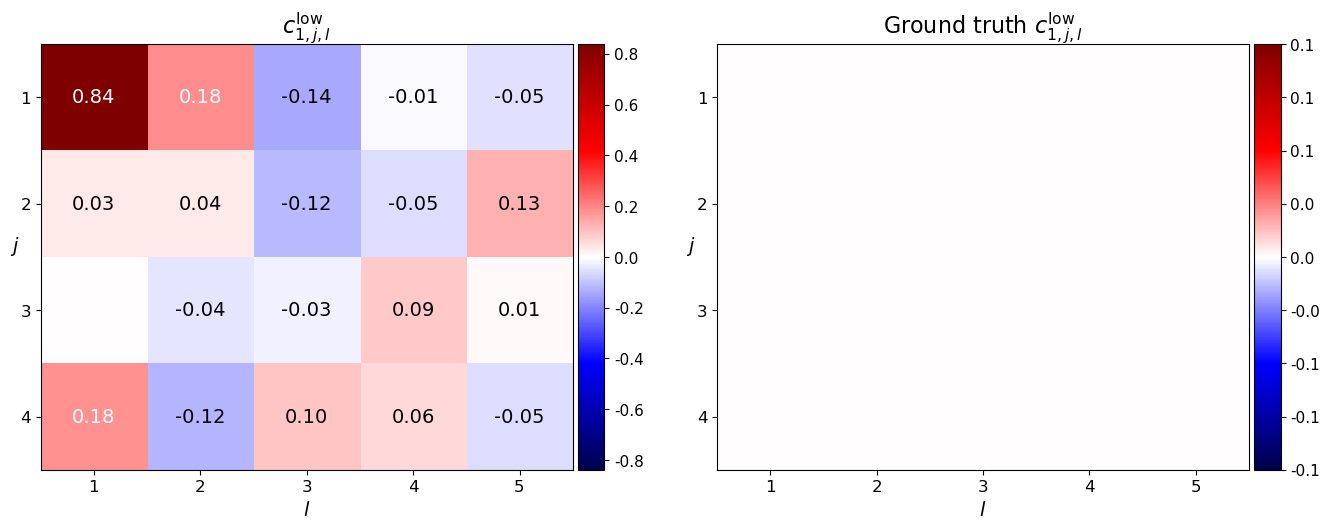

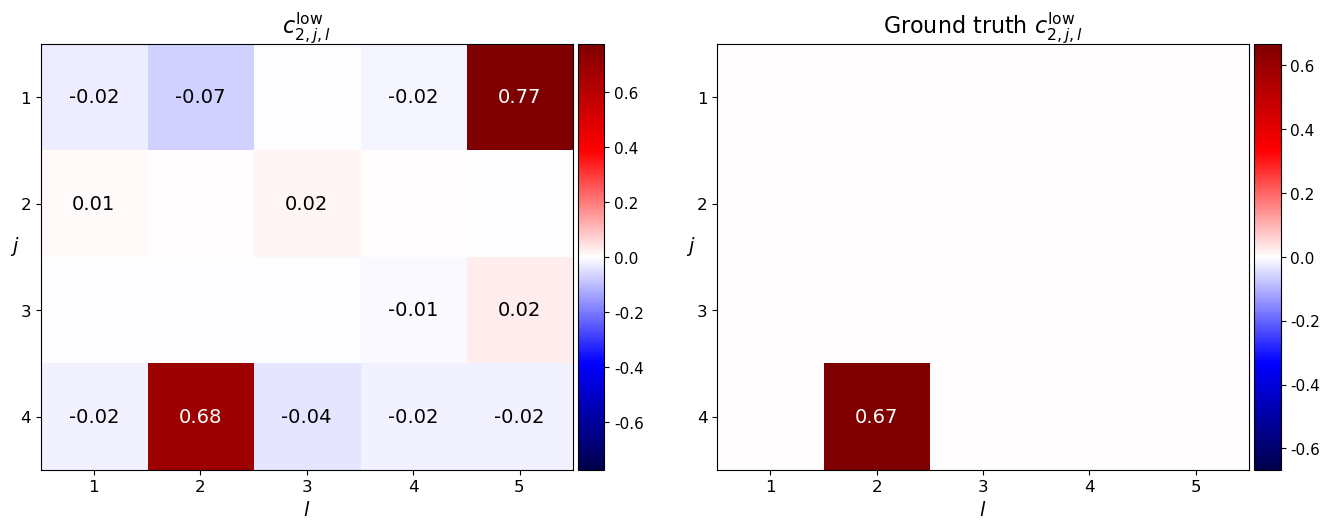

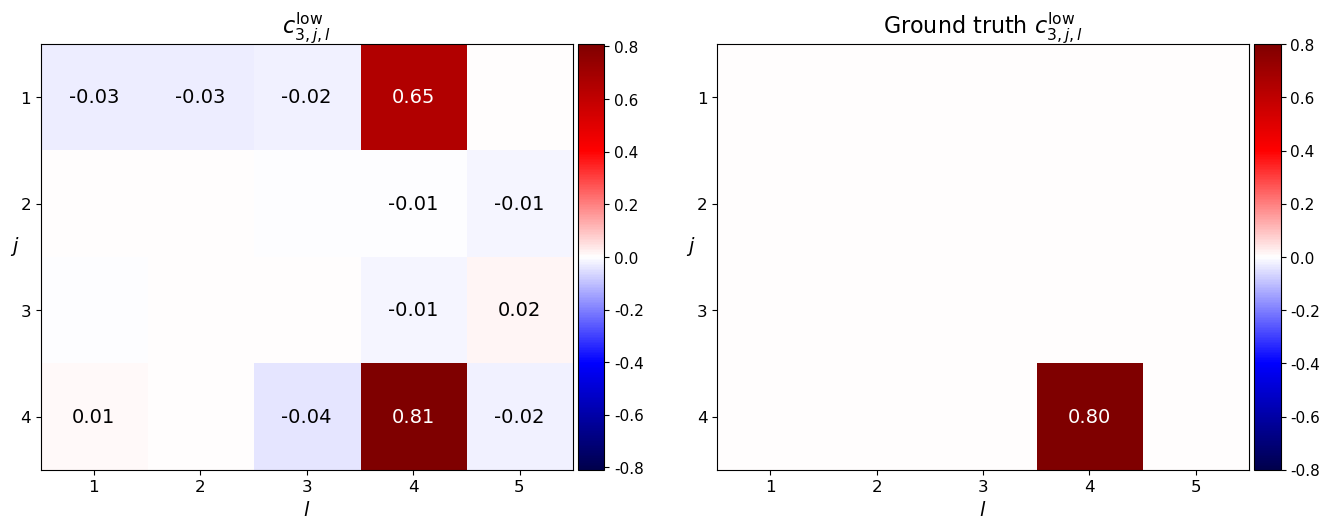

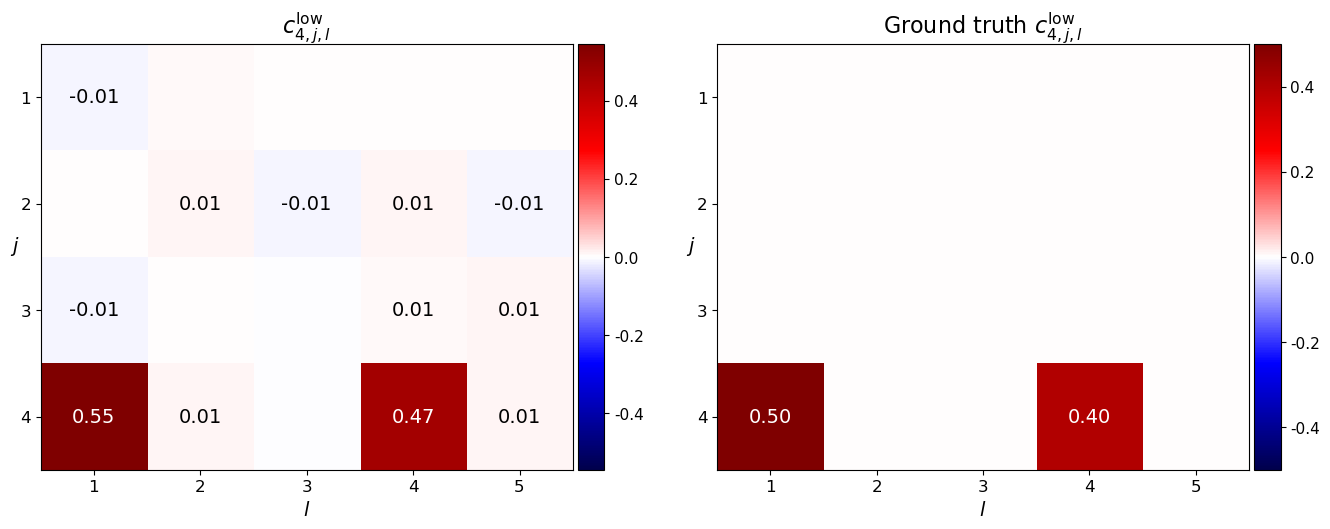

In [55]:
plot_alphas(c_low.mean(0),ground_truth_alpha_low, title=r'c^\text{low}', figsize=(8, 7), font_size=14, space=0.2, force_12=True)

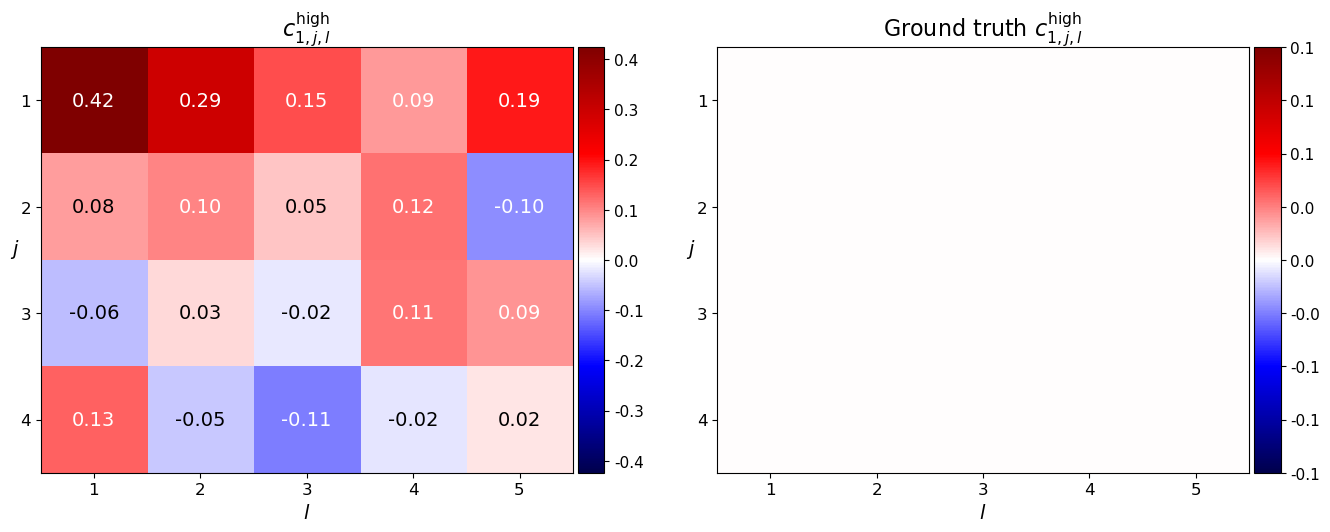

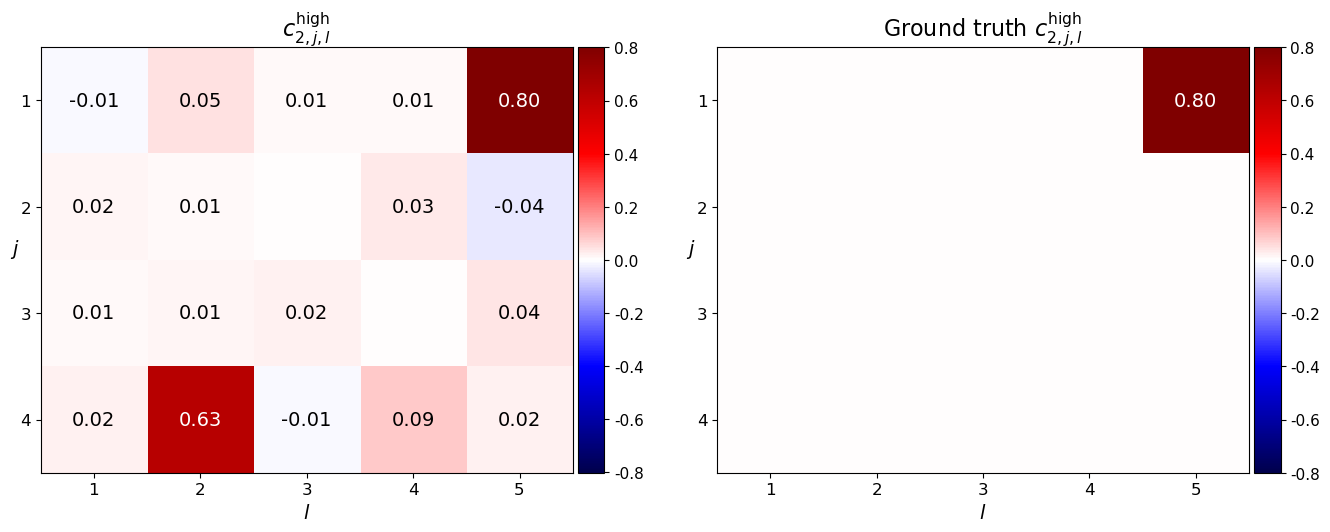

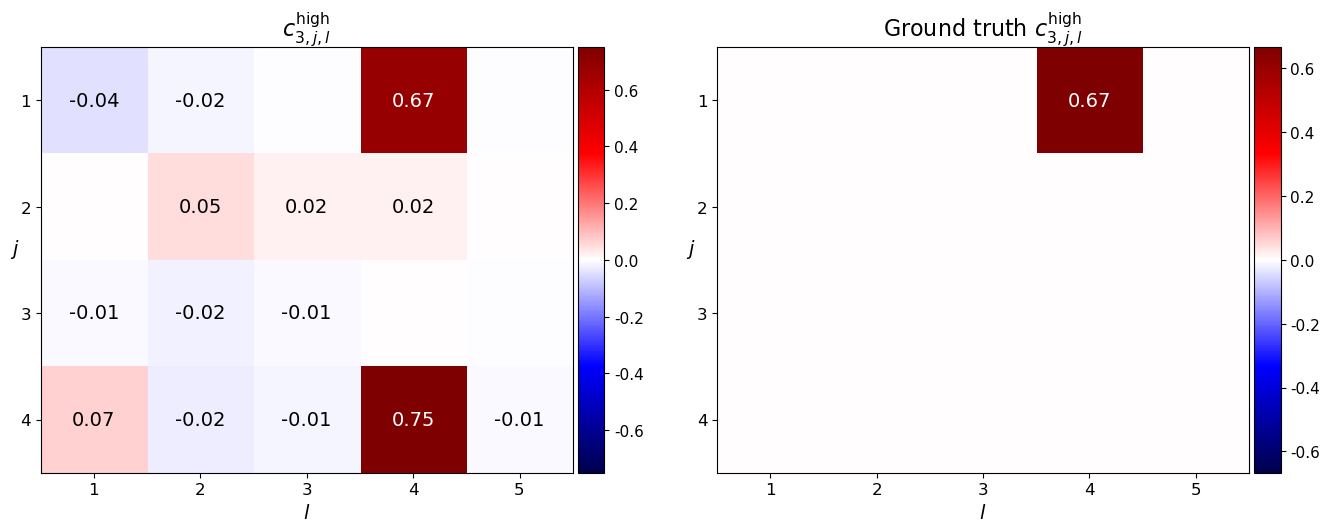

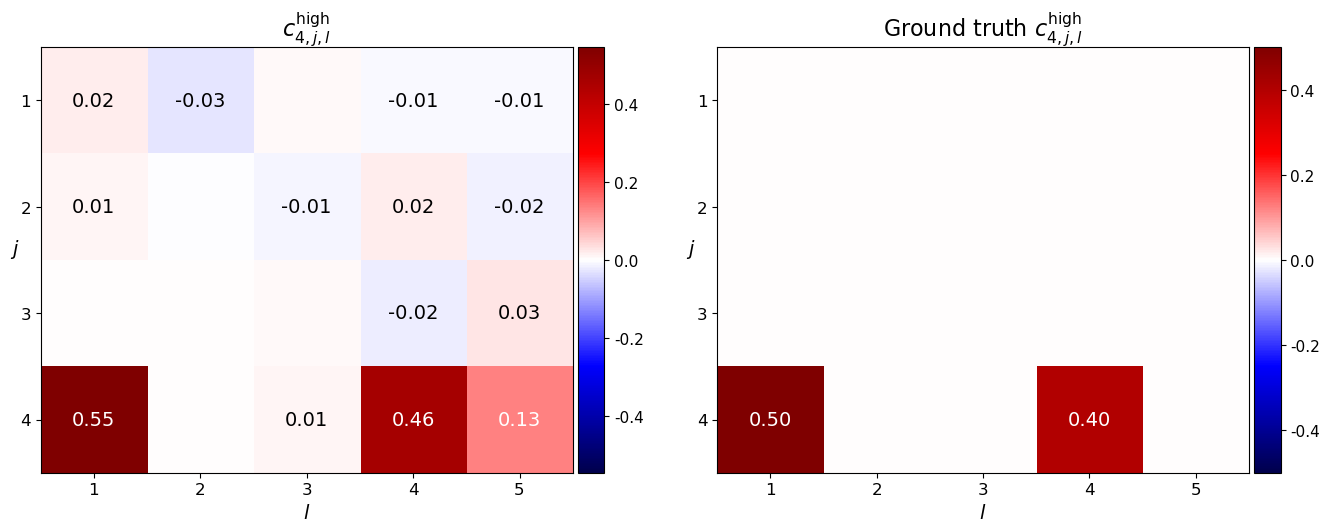

In [56]:
plot_alphas(c_high.mean(0),ground_truth_alpha_high, title=r'c^\text{high}', figsize=(8, 7), font_size=14, space=0.2, force_12=True)

# Test stabitliy on multiple runs

In [57]:
def collect_multiple_runs_mix(
    n_runs: int,
    time_series: torch.Tensor,
    window_size: int,
    temperature: float,
    mask: np.ndarray,
    order: List[int] = None,
    config=None,
    seed: int = 1000,
    verbose: bool = True
) -> Dict:
    """
    Perform multiple runs of the model, split outputs into '_low' and '_high' categories based on a mask, 
    and collect statistics.
    
    Args:
        n_runs (int): Number of runs to perform
        time_series (torch.Tensor): Input time series data
        window_size (int): Size of the sliding window
        temperature (float): Temperature parameter for the model
        mask (np.ndarray): Boolean mask indicating high (True) and low (False) values
        order (List[int], optional): Same as in train_eval (default: [1, 1])
        config (dict): Configuration dictionary with training parameters
        seed (int): Base seed for reproducibility
        verbose (bool): Whether to print progress
        
    Returns:
        Dict: Dictionary containing test losses, and split '_low' and '_high' values for each run
    """
    if order is None:
        order = [1, 1]

    if config is None:
        train_config = {
            'verbose': True,
            'device': device,
            'learning_rate': 1e-3,
            'scheduler_patience': 5,
            'early_stopping_modifier': 2,
            'criterion': nn.MSELoss()
        }
    else:
        train_config = config

    # Print the training configuration
    print("Training Configuration:")
    for key, value in train_config.items():
        print(f"  {key}: {value}")
    
    results = {}
    
    for run in range(n_runs):
        if verbose:
            print(f"Starting Run {run + 1}/{n_runs}")
            
        # Record the start time
        start_time = time.time()
        
        # Set seed for this run
        current_seed = seed + run
        torch.manual_seed(current_seed)
        np.random.seed(current_seed)
        
        # Run the model
        test_loss, train_losses, val_losses, f_test, c_test, debug_info, _, _, _ = train_and_evaluate(
            time_series,
            window_size=window_size,
            temperature=temperature,
            order=order,
            config=train_config
        )
        
        alpha = {}
        alpha_std = {}
        f_means_low = {}
        f_means_high = {}
        c_means_low = {}
        c_means_high = {}

        # Process mask
        for i in f_test.keys():
            if i == 0:
                # Apply mask to f_test[0] and c_test[0]
                f_bias_low = f_test[0][~mask]
                c_bias_low = c_test[0][~mask]
                f_bias_high = f_test[0][mask]
                c_bias_high = c_test[0][mask]

                # Compute alpha_bias and alpha_bias_std for low
                alpha_bias_low = (f_bias_low * c_bias_low).mean(0)
                alpha_bias_std_low = (f_bias_low * c_bias_low).std(0)

                # Compute alpha_bias and alpha_bias_std for high
                alpha_bias_high = (f_bias_high * c_bias_high).mean(0)
                alpha_bias_std_high = (f_bias_high * c_bias_high).std(0)
            else:
                # Apply mask to f_test[i] and c_test[i]
                f_low = f_test[i][~mask]
                c_low = c_test[i][~mask]
                f_high = f_test[i][mask]
                c_high = c_test[i][mask]

                # Compute alpha and alpha_std for low
                alpha[f"{i}_low"] = (f_low * c_low).mean(0)
                alpha_std[f"{i}_low"] = (f_low * c_low).std(0)

                # Compute alpha and alpha_std for high
                alpha[f"{i}_high"] = (f_high * c_high).mean(0)
                alpha_std[f"{i}_high"] = (f_high * c_high).std(0)

                # Collect f_means and c_means
                f_means_low[i] = f_low.mean(0)
                f_means_high[i] = f_high.mean(0)
                c_means_low[i] = c_low.mean(0)
                c_means_high[i] = c_high.mean(0)

        # Store results for this run
        results[f'run_{run + 1}'] = {
            'test_loss': test_loss,
            'alpha': alpha,
            'alpha_std': alpha_std,
            'alpha_bias': {
                'low': {'mean': alpha_bias_low, 'std': alpha_bias_std_low},
                'high': {'mean': alpha_bias_high, 'std': alpha_bias_std_high}
            },
            'f_means': {'low': f_means_low, 'high': f_means_high},
            'c_means': {'low': c_means_low, 'high': c_means_high}
        }
        
        if verbose:
            print(f"Run {run + 1} completed. Test Loss: {test_loss:.6e}")
    
    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for Run {run + 1}: {elapsed_time:.2f} seconds")
    
    # Add summary statistics across runs
    test_losses = [results[f'run_{i + 1}']['test_loss'] for i in range(n_runs)]
    results['summary'] = {
        'mean_test_loss': np.mean(test_losses),
        'std_test_loss': np.std(test_losses),
        'min_test_loss': np.min(test_losses),
        'max_test_loss': np.max(test_losses),
        'best_run': f"run_{np.argmin(test_losses) + 1}"
    }
    
    return results

In [58]:
# Do not print train/eval output
train_config['verbose'] = False

# Collect results from multiple runs
results = collect_multiple_runs_mix(
    n_runs=5,
    time_series=time_series,
    window_size=5,
    temperature=1.0,
    mask=mask,
    order=[1,1],
    config=train_config,
    verbose=True
)

Training Configuration:
  verbose: False
  device: cuda:0
  learning_rate: 0.001
  scheduler_patience: 5
  early_stopping_modifier: 2
  criterion: L1Loss()
Starting Run 1/5
Run 1 completed. Test Loss: 2.574141e-02
Starting Run 2/5
Run 2 completed. Test Loss: 2.580033e-02
Starting Run 3/5
Run 3 completed. Test Loss: 2.582004e-02
Starting Run 4/5
Run 4 completed. Test Loss: 2.574364e-02
Starting Run 5/5
Run 5 completed. Test Loss: 2.577274e-02
Time taken for Run 5: 172.93 seconds


In [59]:
def calculate_multiple_run_statistics_mix(results: Dict) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Calculate mean and standard deviation of alpha, alpha_bias, beta, f_means, and c_means across all runs,
    using '_low' and '_high' categories provided in the results.

    Args:
        results (Dict): Results dictionary from collect_multiple_runs_mix.

    Returns:
        Dict[str, Dict[str, np.ndarray]]: Dictionary containing the mean and standard deviation of
                                          alpha, alpha_bias, beta, f_means, and c_means for each key.
    """
    # Get number of runs
    run_keys = [k for k in results.keys() if k.startswith('run_')]
    n_runs = len(run_keys)

    # Prepare output dictionary
    stats = {
        'alpha_low': {},
        'alpha_high': {},
        'beta_low': {},
        'beta_high': {},
        'f_low': {},
        'f_high': {},
        'c_low': {},
        'c_high': {},
        'alpha_bias_low': {'mean': None, 'std': None},
        'alpha_bias_high': {'mean': None, 'std': None},
    }

    # Get the first run to extract structure
    first_run = results['run_1']
    
    # Process alpha and beta
    alpha_keys = [key for key in first_run['alpha'].keys()]
    
    for key in alpha_keys:
        # Stack all alphas for the current key
        alphas = np.stack([results[f'run_{i+1}']['alpha'][key] for i in range(n_runs)], axis=0)
        alpha_stds = np.stack([results[f'run_{i+1}']['alpha_std'][key] for i in range(n_runs)], axis=0)
        
        # Calculate beta for each run
        betas = np.empty(alphas.shape[:-1])  # Shape: (n_runs, height, width)
        
        for i in range(n_runs):
            beta_tilde = np.abs(alphas[i]).sum(axis=-1)
            betas[i] = beta_tilde / beta_tilde.sum(axis=1, keepdims=True)  # Normalize
        
        # Store results based on whether key ends with '_low' or '_high'
        category = 'low' if key.endswith('_low') else 'high'
        base_key = int(key.replace('_low', '').replace('_high', ''))  # Convert to integer
        
        stats[f'alpha_{category}'][base_key] = {
            'mean': np.mean(alphas, axis=0),
            'std': np.std(alphas, axis=0)
        }
        stats[f'beta_{category}'][base_key] = {
            'mean': np.mean(betas, axis=0),
            'std': np.std(betas, axis=0)
        }

    # Process alpha_bias
    alpha_bias_low = np.stack([results[f'run_{i+1}']['alpha_bias']['low']['mean'] for i in range(n_runs)], axis=0)
    alpha_bias_high = np.stack([results[f'run_{i+1}']['alpha_bias']['high']['mean'] for i in range(n_runs)], axis=0)
    
    stats['alpha_bias_low'] = {
        'mean': np.mean(alpha_bias_low, axis=0),
        'std': np.std(alpha_bias_low, axis=0)
    }
    stats['alpha_bias_high'] = {
        'mean': np.mean(alpha_bias_high, axis=0),
        'std': np.std(alpha_bias_high, axis=0)
    }

    # Process f_means and c_means
    # Extract numeric keys from f_means
    f_keys = list(first_run['f_means']['low'].keys())
    
    for key in f_keys:
        # Stack f_means
        f_means_low = np.stack([results[f'run_{i+1}']['f_means']['low'][key] for i in range(n_runs)], axis=0)
        f_means_high = np.stack([results[f'run_{i+1}']['f_means']['high'][key] for i in range(n_runs)], axis=0)
        
        # Stack c_means
        c_means_low = np.stack([results[f'run_{i+1}']['c_means']['low'][key] for i in range(n_runs)], axis=0)
        c_means_high = np.stack([results[f'run_{i+1}']['c_means']['high'][key] for i in range(n_runs)], axis=0)

        stats['f_low'][key] = {
            'mean': np.mean(f_means_low, axis=0),
            'std': np.std(f_means_low, axis=0)
        }
        stats['f_high'][key] = {
            'mean': np.mean(f_means_high, axis=0),
            'std': np.std(f_means_high, axis=0)
        }
        stats['c_low'][key] = {
            'mean': np.mean(c_means_low, axis=0),
            'std': np.std(c_means_low, axis=0)
        }
        stats['c_high'][key] = {
            'mean': np.mean(c_means_high, axis=0),
            'std': np.std(c_means_high, axis=0)
        }

    return stats

In [60]:
stats = calculate_multiple_run_statistics_mix(results)

In [61]:
stats.keys()

dict_keys(['alpha_low', 'alpha_high', 'beta_low', 'beta_high', 'f_low', 'f_high', 'c_low', 'c_high', 'alpha_bias_low', 'alpha_bias_high'])

In [62]:
print_bias(stats['alpha_bias_low']['mean'],stats['alpha_bias_low']['std'], ground_truth_bias_low)

bias_1 = (0.196 ± 0.004), gt_bias_1 = 0.200
bias_2 = (0.0003 ± 0.0004), gt_bias_2 = 0.0000
bias_3 = (-0.0001 ± 0.0004), gt_bias_3 = 0.0000
bias_4 = (-0.00000 ± 0.00002), gt_bias_4 = 0.00000


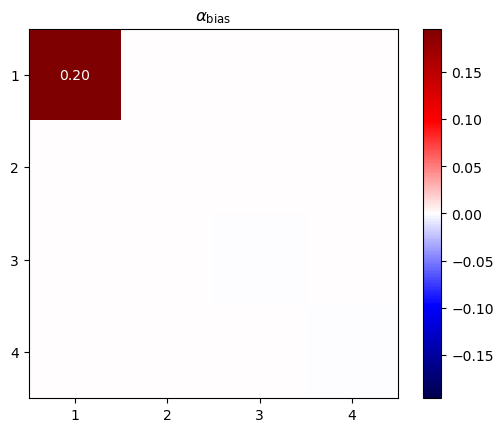

In [63]:
plot_bias(stats['alpha_bias_low']['mean'])

In [64]:
print_bias(stats['alpha_bias_high']['mean'],stats['alpha_bias_high']['std'], ground_truth_bias_low)

bias_1 = (0.196 ± 0.004), gt_bias_1 = 0.200
bias_2 = (0.0003 ± 0.0004), gt_bias_2 = 0.0000
bias_3 = (-0.0001 ± 0.0004), gt_bias_3 = 0.0000
bias_4 = (-0.00000 ± 0.00002), gt_bias_4 = 0.00000


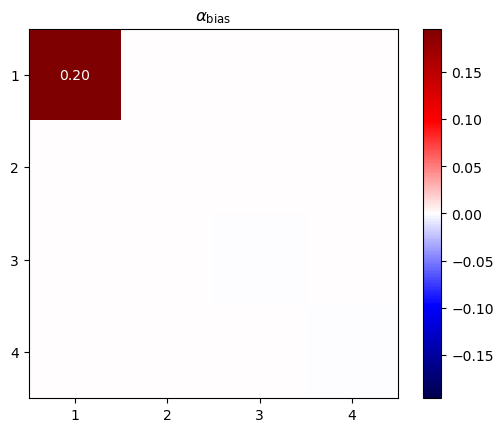

In [65]:
plot_bias(stats['alpha_bias_high']['mean'])

In [66]:
print_significant_alpha(stats['alpha_low'][1]['mean'], stats['alpha_low'][1]['std'],ground_truth_alpha_low, threshold=0.05)

alpha_111 = (0.06 ± 0.02) Not in ground truth
alpha_242 = (0.6663 ± 0.0005), gt_alpha_242 = 0.6667
alpha_344 = (0.800 ± 0.001), gt_alpha_344 = 0.800
alpha_441 = (0.5001 ± 0.0002), gt_alpha_441 = 0.5000
alpha_444 = (0.4001 ± 0.0003), gt_alpha_444 = 0.4000


In [67]:
print_significant_alpha(stats['alpha_high'][1]['mean'], stats['alpha_high'][1]['std'],ground_truth_alpha_high, threshold=0.01)

alpha_111 = (0.49 ± 0.04) Not in ground truth
alpha_215 = (0.796 ± 0.005), gt_alpha_215 = 0.800
alpha_314 = (0.665 ± 0.002), gt_alpha_314 = 0.667
alpha_441 = (0.4999 ± 0.0001), gt_alpha_441 = 0.5000
alpha_444 = (0.4002 ± 0.0006), gt_alpha_444 = 0.4000


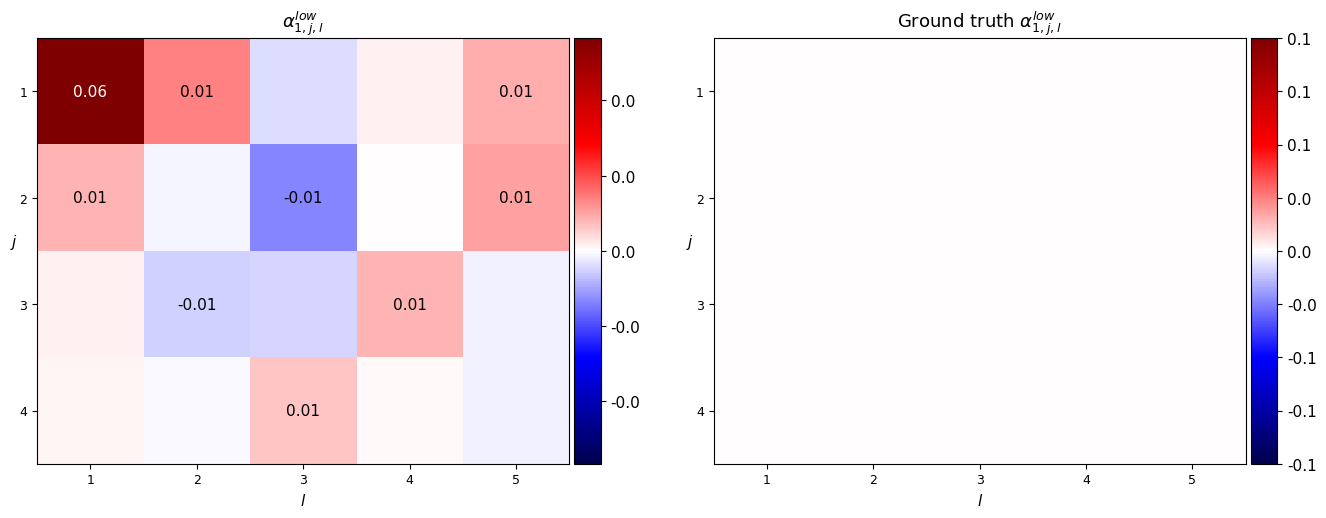

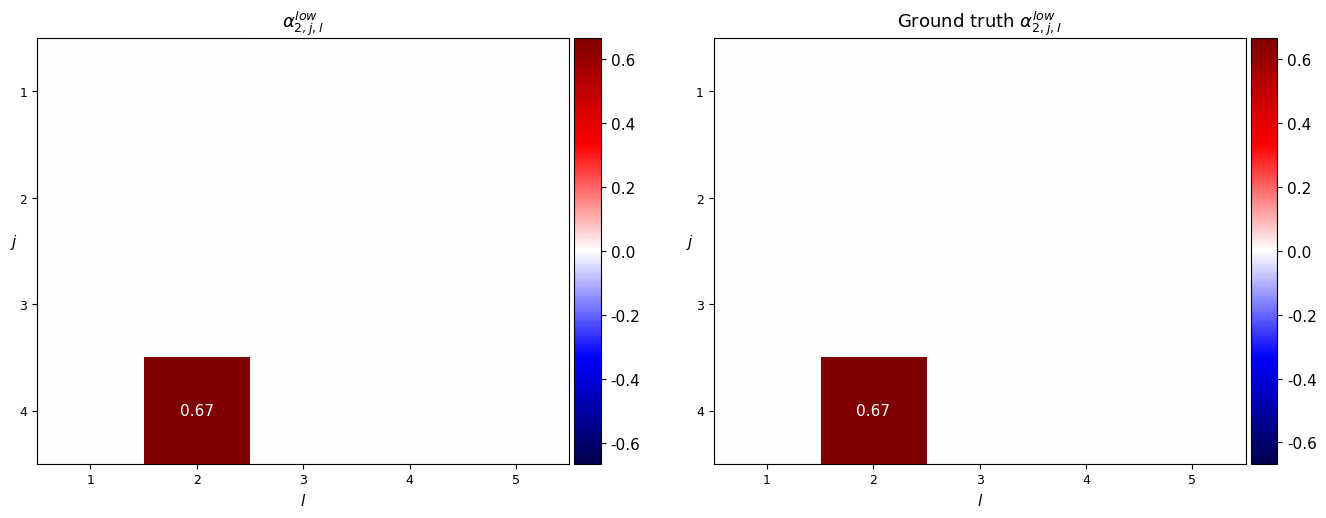

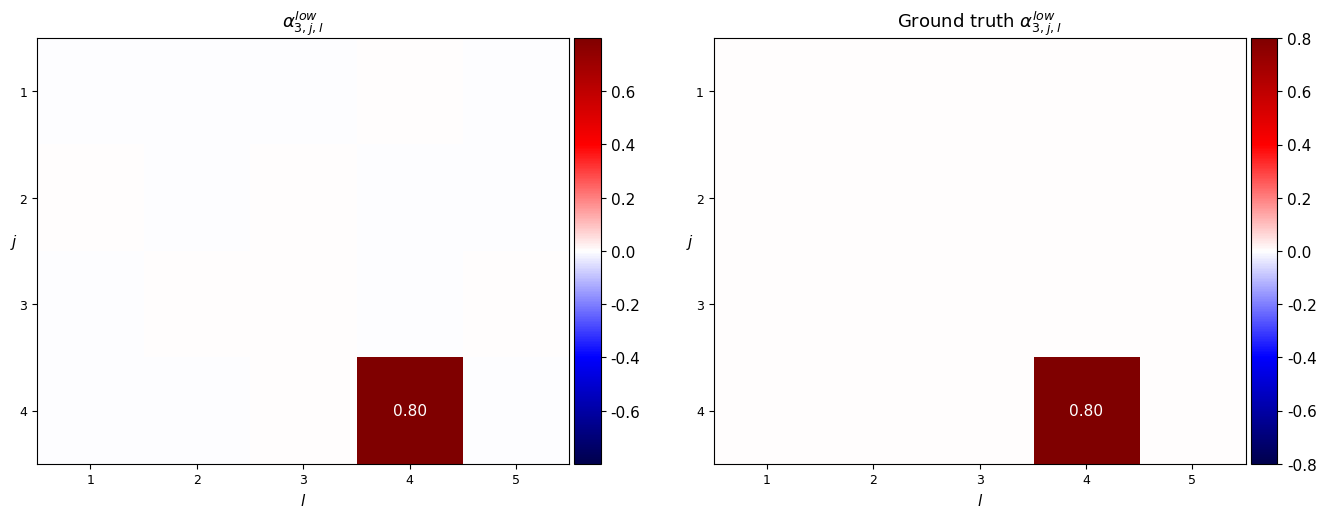

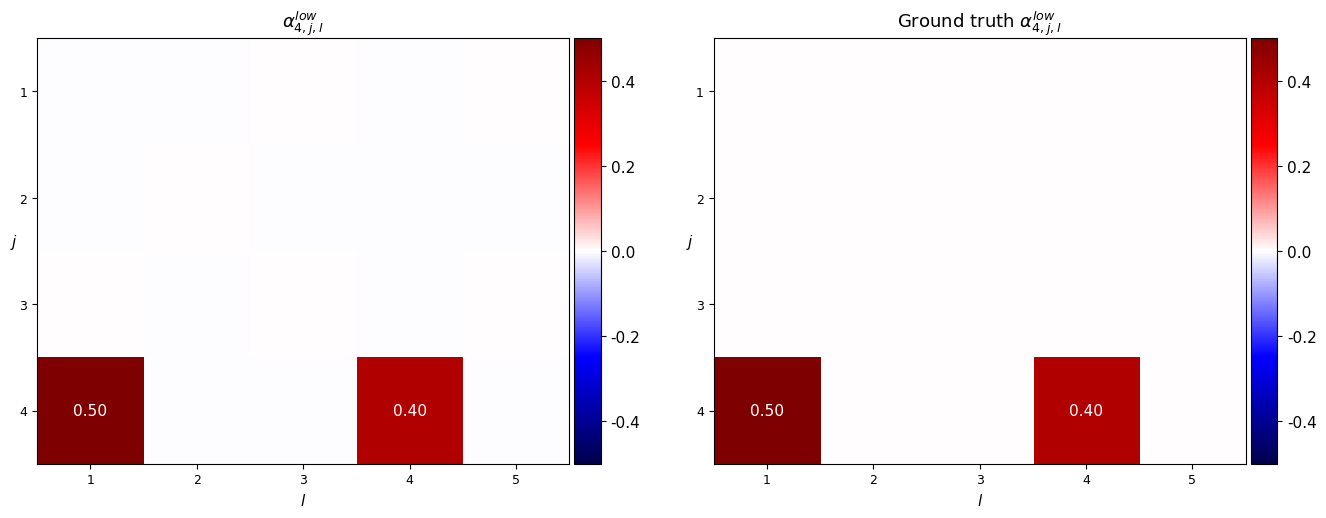

In [68]:
plot_alphas(stats['alpha_low'][1]['mean'],ground_truth_alpha_low, figsize=(8, 7), title=r'\alpha^{low}', font_size=11, space=0.2, force_12=True)

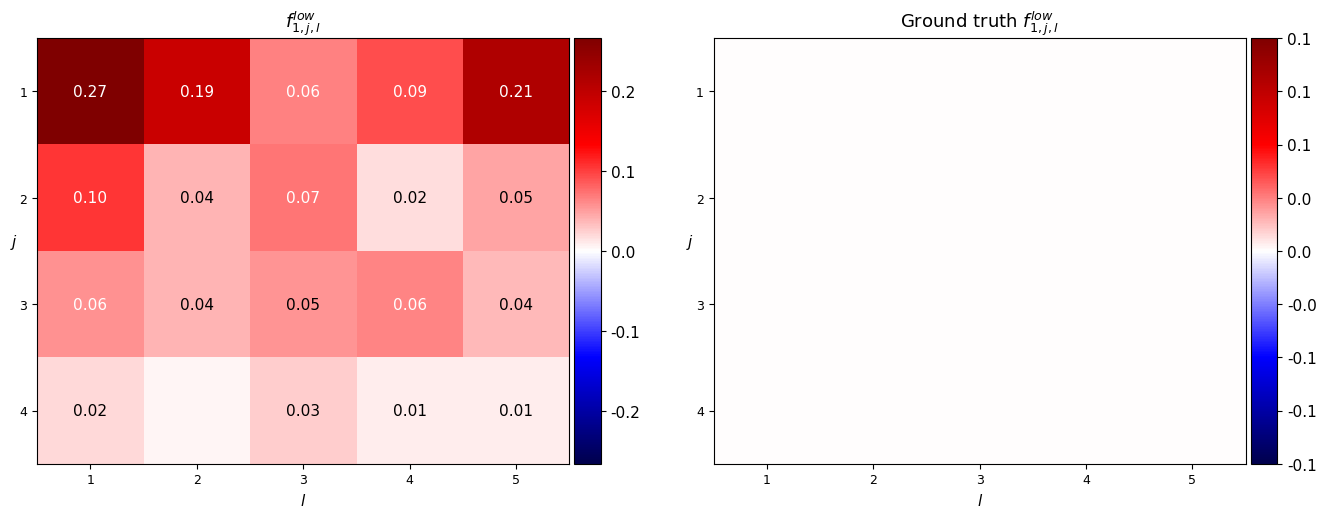

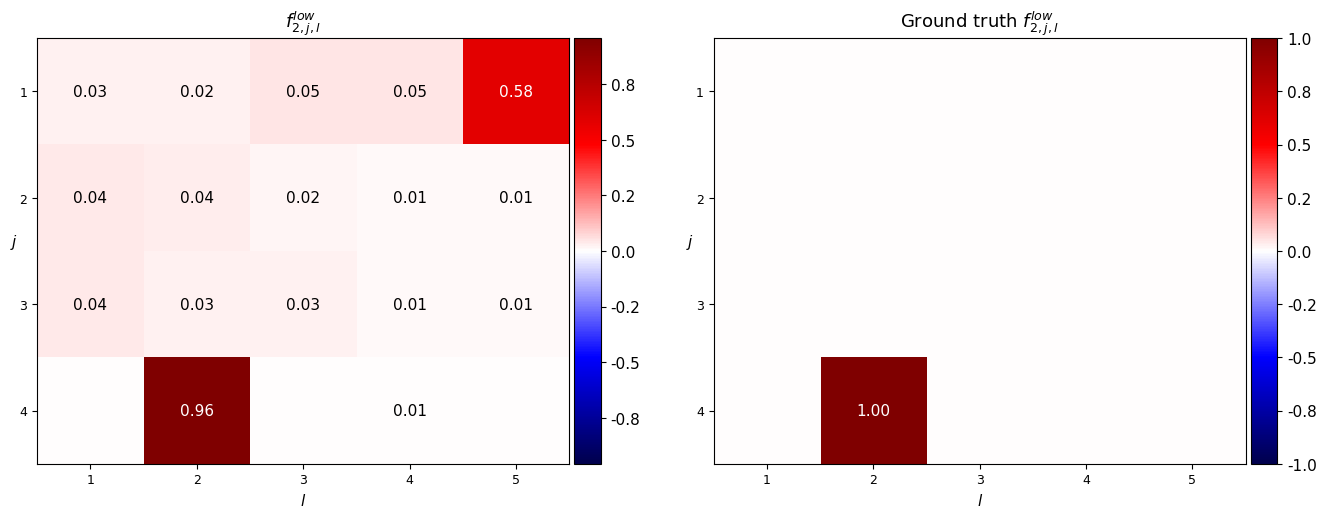

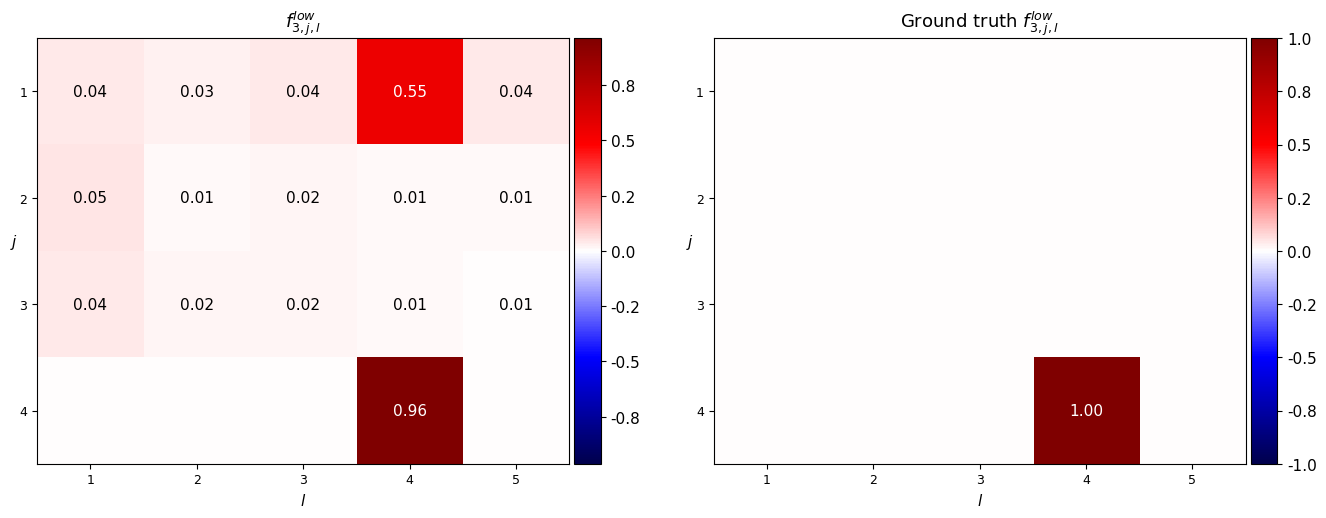

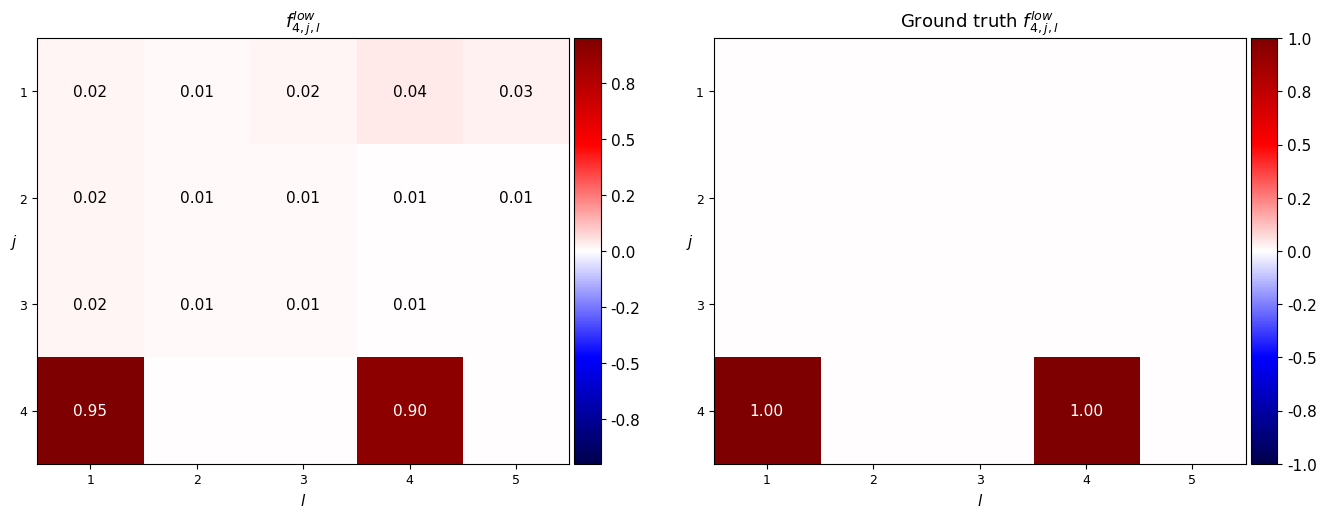

In [69]:
plot_alphas(stats['f_low'][1]['mean'],alpha_mask_low, figsize=(8, 7), title=r'f^{low}', font_size=11, space=0.2, force_12=True)

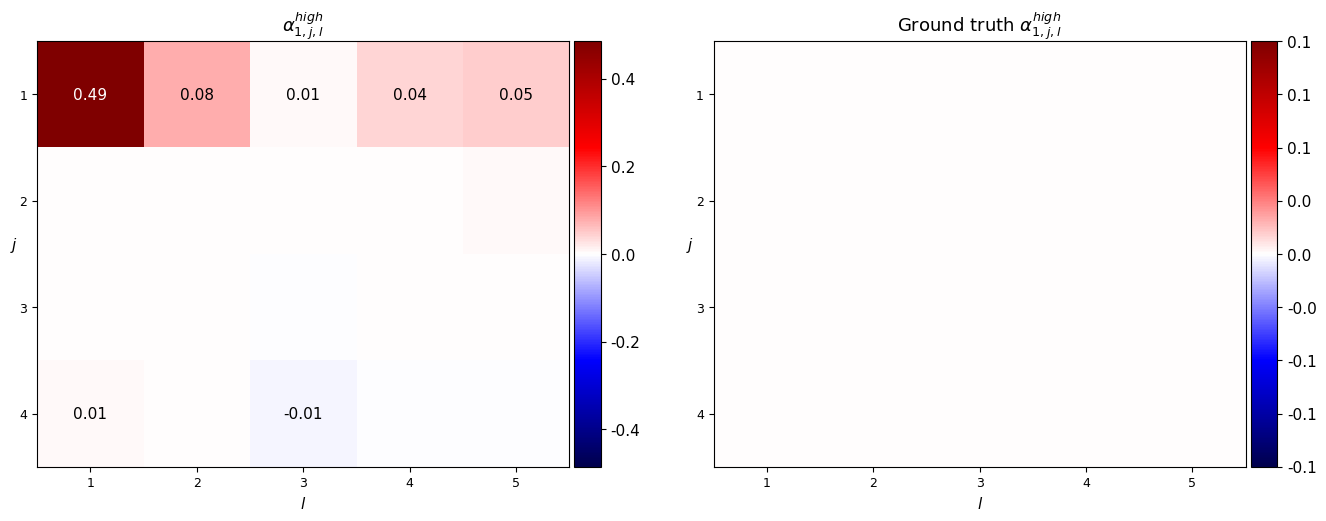

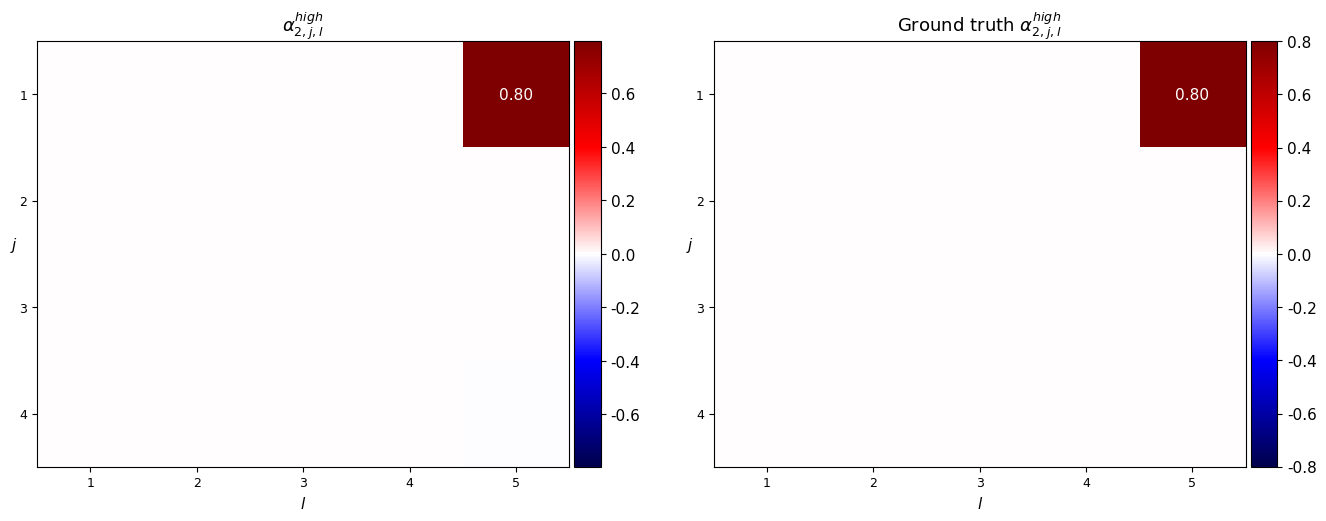

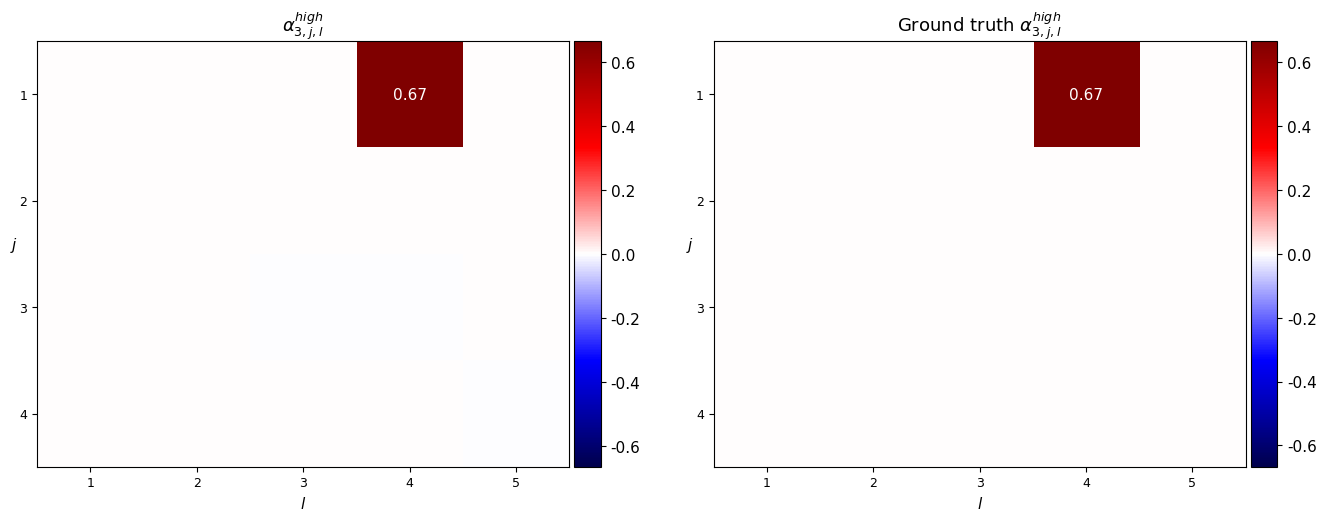

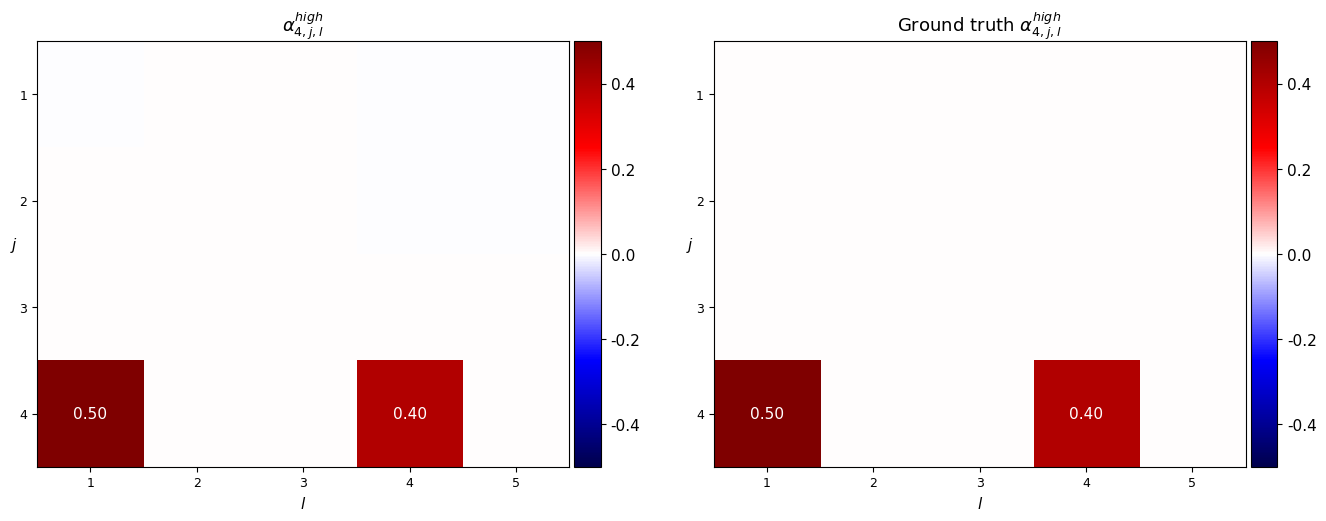

In [70]:
plot_alphas(stats['alpha_high'][1]['mean'],ground_truth_alpha_high, figsize=(8, 7), title=r'\alpha^{high}', font_size=11, space=0.2, force_12=True)

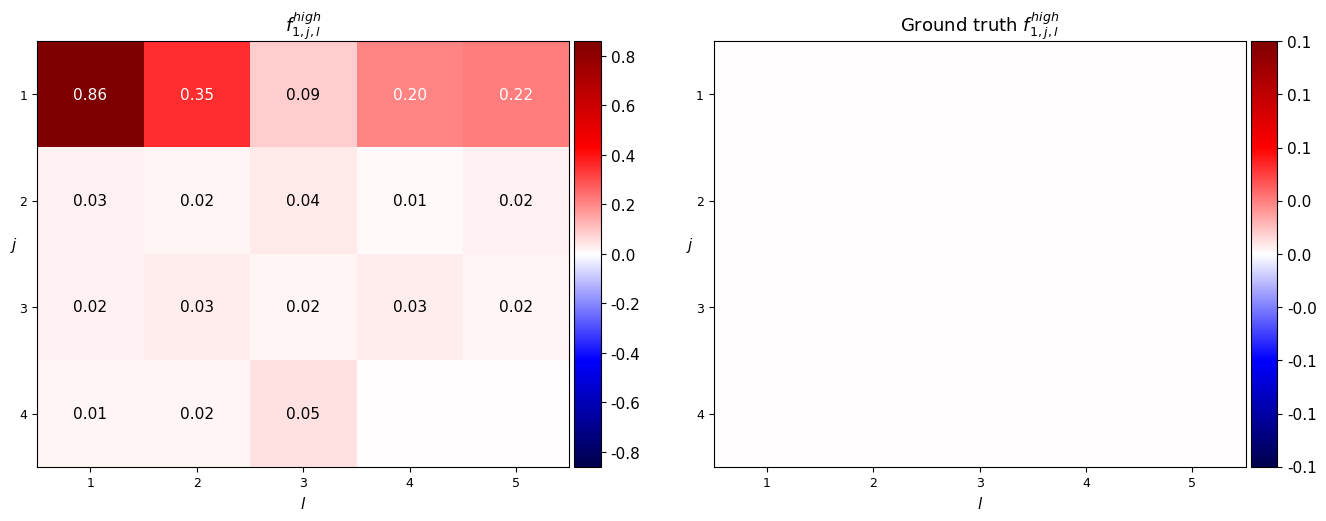

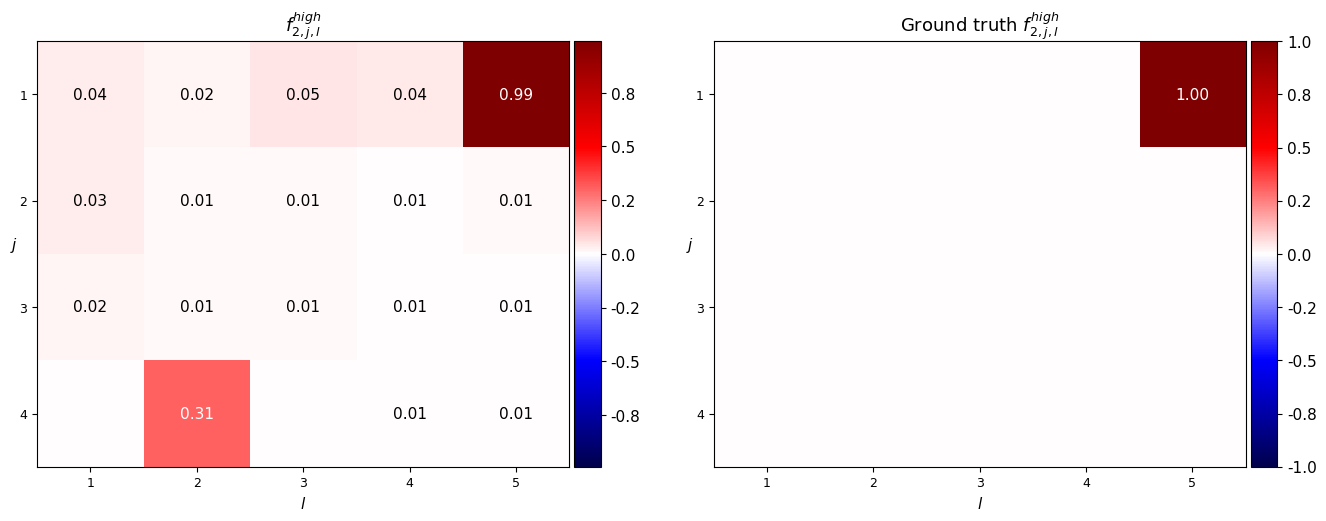

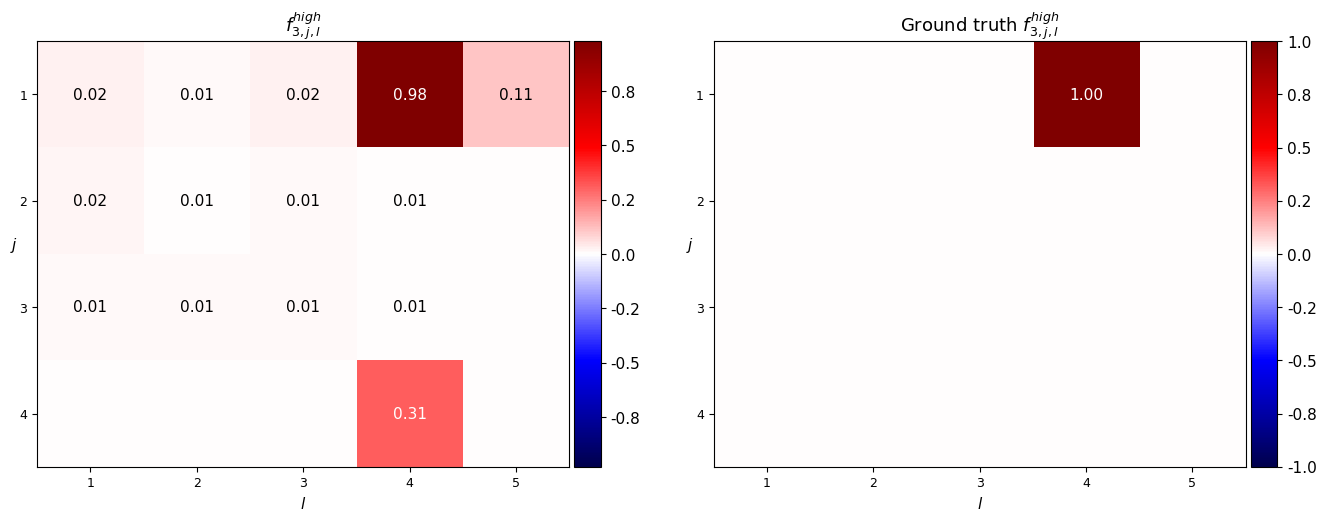

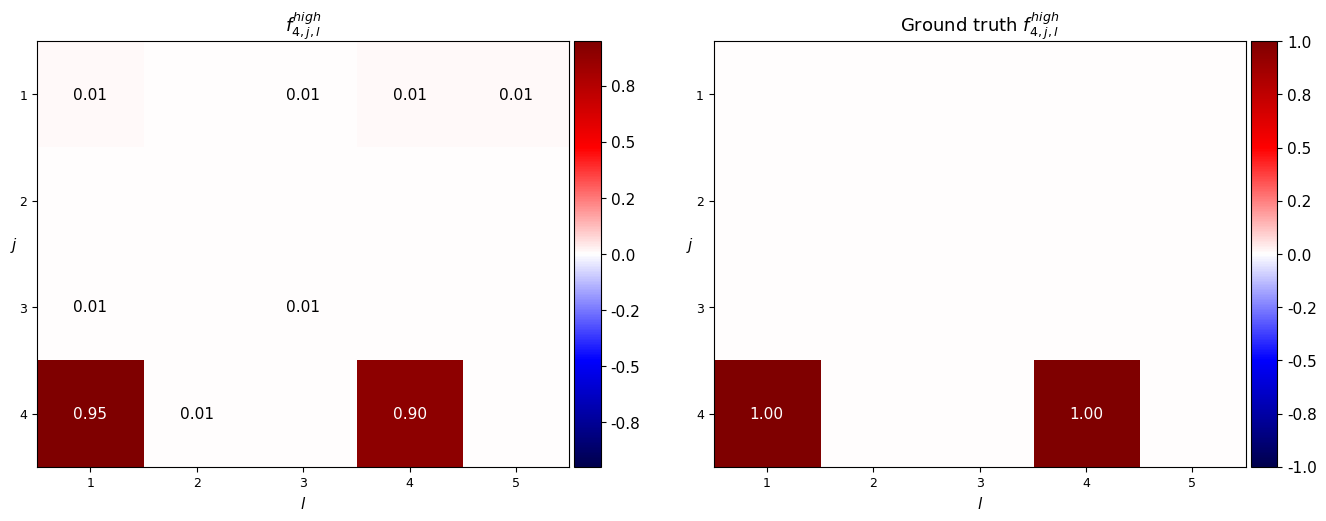

In [71]:
plot_alphas(stats['f_high'][1]['mean'],alpha_mask_high, figsize=(8, 7), title=r'f^{high}', font_size=11, space=0.2, force_12=True)